In [1]:
import warnings


warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [ ]:
"""
==========================================
TEMPORAL FUSION TRANSFORMER (TFT) MODEL
For Energy Demand Forecasting
==========================================

This notebook implements a Temporal Fusion Transformer model using PyTorch Lightning
and pytorch-forecasting library for multi-step ahead forecasting of electricity demand.

Key Features:
- Handles multiple interdependent demand channels (TPCODL, TPWODL, TPNODL, TPSOSDL)
- Uses attention mechanisms to learn temporal dependencies
- Incorporates both known (calendar features) and unknown (demand) variables
- Provides interpretability through attention weight visualization

Dataset: 15-minute interval electricity demand data from January 2017 onwards
Target: Forecast demand 1-6 hours ahead (4-24 time steps at 15-min intervals)
"""

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

In [76]:
"""
STEP 1: LOAD AND PREPROCESS DATA
==================================

This section loads:
1. Electricity demand dataset (2026_proper_data_cleaned.csv)
2. Actual weather data (weather_actual.csv) - past/historical weather
3. Weather forecast data (weather_forecast.csv) - future weather predictions

Dataset structure:
- Demand: Timestamp, zone demand columns (TPCODL, TPWODL, TPNODL, TPSOSDL)
- Weather: district_id (maps to zones), time, temperature, humidity, precipitation, etc.

DATA FILTERING: Using data from July 2025 onwards for better weather data coverage

This allows the model to learn weather-demand relationships from historical data
and use weather forecasts for future demand predictions.

Data transformation:
- Reshape demand to zone-based long format
- Merge actual weather with historical demand
- Keep forecast weather separate for future predictions
"""

print("=" * 80)
print("STEP 1: LOADING DATA (From July 2025 onwards)")
print("=" * 80)

# Load demand data
print("\n1. Loading demand data...")
data_raw = pd.read_csv('../utils/2026_proper_data_cleaned.csv')
data_raw['Timestamp'] = pd.to_datetime(data_raw['Timestamp'])
data_raw = data_raw.sort_values('Timestamp').reset_index(drop=True)

# FILTER: Keep only data from July 2025 onwards
cutoff_date = pd.Timestamp('2025-07-01')
data_raw = data_raw[data_raw['Timestamp'] >= cutoff_date].reset_index(drop=True)

print(f"   ✓ Demand data loaded: {data_raw.shape}")
print(f"   Date range: {data_raw['Timestamp'].min()} to {data_raw['Timestamp'].max()}")

# Load actual weather data (historical)
print("\n2. Loading actual weather data (historical)...")
weather_actual = pd.read_csv('../Analysis/weather_actual.csv')
weather_actual['time'] = pd.to_datetime(weather_actual['time'])

# FILTER: Keep only weather data from July 2025 onwards
weather_actual = weather_actual[weather_actual['time'] >= cutoff_date].reset_index(drop=True)

print(f"   ✓ Actual weather loaded: {weather_actual.shape}")
print(f"   Columns: {weather_actual.columns.tolist()}")
print(f"   Date range: {weather_actual['time'].min()} to {weather_actual['time'].max()}")

# Load weather forecast data (future)
print("\n3. Loading weather forecast data (future predictions)...")
weather_forecast = pd.read_csv('../Analysis/weather_forecast.csv')
weather_forecast['time'] = pd.to_datetime(weather_forecast['time'])
weather_forecast['prediction_time'] = pd.to_datetime(weather_forecast['prediction_time'])
print(f"   ✓ Weather forecast loaded: {weather_forecast.shape}")
print(f"   Columns: {weather_forecast.columns.tolist()}")
print(f"   Date range: {weather_forecast['time'].min()} to {weather_forecast['time'].max()}")

# ============================================================================
# CREATE ZONE-TO-DISTRICT MAPPING
# ============================================================================
# Weather data uses district_id; demand data uses zone names
# Create mapping between them
zone_columns = ['TPCODL Demand', 'TPWODL Demand', 'TPNODL Demand', 'TPSOSDL Demand', 'Total Demand (as recorded)']
zone_mapping = {
    'TPCODL Demand': 'TPCODL',
    'TPWODL Demand': 'TPWODL',
    'TPNODL Demand': 'TPNODL',
    'TPSOSDL Demand': 'TPSOSDL',
    'Total Demand (as recorded)': 'TOTAL'
}

# Map zones to district IDs (adjust if needed based on your data)
zone_to_district = {
    'TPCODL': 6,
    'TPWODL': 6,
    'TPNODL': 6,
    'TPSOSDL': 6,
    'TOTAL': 6
}

print(f"\n4. Zone to District mapping:")
for zone, district_id in zone_to_district.items():
    print(f"   {zone} ↔ district_id {district_id}")

# ============================================================================
# RESHAPE DEMAND TO ZONE FORMAT
# ============================================================================
print(f"\n5. Converting demand data to zone-based format...")

data = pd.concat([
    data_raw[['Timestamp']].assign(
        zone_id=zone_name,
        demand=data_raw[col_name].values
    )
    for col_name, zone_name in zone_mapping.items()
], ignore_index=True)

data = data.sort_values(['Timestamp', 'zone_id']).reset_index(drop=True)
data['zone_id'] = data['zone_id'].astype('category')

print(f"   ✓ Demand reshaped to long format: {data.shape}")
print(f"   Zones: {data['zone_id'].unique().tolist()}")

# ============================================================================
# MERGE WEATHER DATA WITH DEMAND
# ============================================================================
print(f"\n6. Merging weather with demand data...")

# Prepare weather_actual for merging
# Rename columns to match with demand data and add zone_id
weather_actual['zone_id'] = weather_actual['district_id'].map(
    {v: k for k, v in zone_to_district.items()}
)
weather_actual = weather_actual.rename(columns={'time': 'Timestamp'})

# Select weather features to keep
weather_features = ['temperature', 'humidity', 'precipitation', 'rain', 
                   'surface_pressure', 'wind_speed', 'wind_direction']

weather_actual_merged = weather_actual[['Timestamp', 'zone_id'] + weather_features].copy()

# Merge with demand data
data = data.merge(
    weather_actual_merged,
    on=['Timestamp', 'zone_id'],
    how='left'
)

print(f"   ✓ Weather merged successfully: {data.shape}")

# Handle any missing weather values (forward fill within each zone)
print(f"\n7. Handling missing weather values (aggressive filling strategy)...")
for col in weather_features:
    if col in data.columns:
        missing_before = data[col].isnull().sum()
        
        # Strategy 1: Forward fill per zone
        data[col] = data.groupby('zone_id')[col].fillna(method='ffill')
        # Strategy 2: Backward fill for early records
        data[col] = data.groupby('zone_id')[col].fillna(method='bfill')
        # Strategy 3: Global mean for any remaining
        if data[col].isnull().sum() > 0:
            global_mean = data[col].mean()
            data[col] = data[col].fillna(global_mean)
        
        missing_after = data[col].isnull().sum()
        print(f"   {col:20s}: {missing_before:6d} missing → {missing_after:6d} missing")

# ============================================================================
# CREATE TIME INDEX AND TEMPORAL FEATURES
# ============================================================================
print(f"\n8. Creating temporal features...")

data['time_idx'] = data.groupby('zone_id').cumcount()

# Calendar features
data['hour'] = data['Timestamp'].dt.hour.astype(str).astype('category')
data['day_of_week'] = data['Timestamp'].dt.dayofweek.astype(str).astype('category')
data['month'] = data['Timestamp'].dt.month.astype(str).astype('category')
data['quarter'] = data['Timestamp'].dt.quarter.astype(str).astype('category')
data['day_of_month'] = data['Timestamp'].dt.day.astype(str).astype('category')

print(f"   ✓ Temporal features created")

# ============================================================================
# ZONE-SPECIFIC STATISTICS
# ============================================================================
print(f"\n9. Computing zone-specific statistics...")

data['avg_demand_by_hour_zone'] = data.groupby(
    ['zone_id', 'hour'], observed=True
)['demand'].transform('mean')

data['std_demand_by_hour_zone'] = data.groupby(
    ['zone_id', 'hour'], observed=True
)['demand'].transform('std')

data['rolling_mean_1h'] = data.groupby('zone_id')['demand'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

data['rolling_mean_6h'] = data.groupby('zone_id')['demand'].transform(
    lambda x: x.rolling(window=24, min_periods=1).mean()
)

data['log_demand'] = np.log(data['demand'] + 1)

print(f"   ✓ Statistics computed")

# ============================================================================
# SAVE WEATHER FORECAST FOR LATER USE
# ============================================================================
# We'll use this for future predictions
print(f"\n10. Preparing weather forecast for future predictions...")

weather_forecast['zone_id'] = weather_forecast['district_id'].map(
    {v: k for k, v in zone_to_district.items()}
)
weather_forecast = weather_forecast.rename(columns={'time': 'Timestamp'})

# Keep only the latest forecast (latest prediction_time)
latest_prediction_time = weather_forecast['prediction_time'].max()
weather_forecast_latest = weather_forecast[
    weather_forecast['prediction_time'] == latest_prediction_time
].copy()

weather_forecast_latest = weather_forecast_latest[
    ['Timestamp', 'zone_id'] + weather_features
].sort_values(['Timestamp', 'zone_id']).reset_index(drop=True)

# Fill missing forecast weather values
for col in weather_features:
    missing = weather_forecast_latest[col].isnull().sum()
    if missing > 0:
        weather_forecast_latest[col] = weather_forecast_latest.groupby('zone_id')[col].fillna(method='ffill')
        weather_forecast_latest[col] = weather_forecast_latest.groupby('zone_id')[col].fillna(method='bfill')
        if weather_forecast_latest[col].isnull().sum() > 0:
            weather_forecast_latest[col] = weather_forecast_latest[col].fillna(
                weather_forecast_latest[col].mean()
            )

print(f"   ✓ Latest weather forecast selected: {weather_forecast_latest.shape}")
print(f"   Forecast range: {weather_forecast_latest['Timestamp'].min()} to {weather_forecast_latest['Timestamp'].max()}")

print(f"\n" + "=" * 80)
print(f"SUMMARY")
print(f"=" * 80)
print(f"Demand data shape: {data.shape}")
print(f"Zones: {data['zone_id'].nunique()}")
print(f"Time period: {data['Timestamp'].min()} to {data['Timestamp'].max()}")
print(f"Data duration: {(data['Timestamp'].max() - data['Timestamp'].min()).days} days")
print(f"Weather features available: {weather_features}")
print(f"Forecast data ready: {weather_forecast_latest.shape}")
print(f"\n✓ Using high-quality weather data from July 2025 onwards")
print(f"✓ Missing values minimized with aggressive filling strategy")
print(f"\nData dtypes:\n{data.dtypes}")

STEP 1: LOADING DATA (From July 2025 onwards)

1. Loading demand data...
   ✓ Demand data loaded: (19045, 6)
   Date range: 2025-07-01 00:00:00 to 2026-01-15 09:00:00

2. Loading actual weather data (historical)...
   ✓ Actual weather loaded: (514330, 10)
   Columns: ['id', 'district_id', 'time', 'temperature', 'humidity', 'precipitation', 'rain', 'surface_pressure', 'wind_speed', 'wind_direction']
   Date range: 2025-07-01 00:00:00 to 2026-01-17 15:00:00

3. Loading weather forecast data (future predictions)...
   ✓ Weather forecast loaded: (1046688, 12)
   Columns: ['id', 'district_id', 'time', 'prediction_time', 'temperature', 'humidity', 'precipitation', 'rain', 'surface_pressure', 'wind_speed', 'wind_direction', 'prediction_type']
   Date range: 2025-06-28 18:30:00 to 2026-01-17 23:45:00

4. Zone to District mapping:
   TPCODL ↔ district_id 6
   TPWODL ↔ district_id 6
   TPNODL ↔ district_id 6
   TPSOSDL ↔ district_id 6
   TOTAL ↔ district_id 6

5. Converting demand data to zone-b

In [77]:
"""
DATA QUALITY CHECK & WEATHER INTEGRATION GUIDE
===================================================

This cell performs data quality checks and shows how to integrate weather data.

CURRENT DATA STRUCTURE:
- Zone-based format: Each zone (TPCODL, TPWODL, TPNODL, TPSOSDL) is a separate time series
- 15-minute intervals
- Available features: Calendar (hour, day, month, etc.) and zone statistics
- Weather features: temperature, humidity, precipitation, wind_speed, surface_pressure, wind_direction, rain

WEATHER DATA INTEGRATION: ✓ COMPLETE

You now have:
1. Historical weather (weather_actual.csv) - Merged with demand data for training
2. Forecast weather (weather_forecast.csv) - Ready for future predictions

The model learns the relationship between weather and demand:
- Temperature → Demand (heating/cooling effects)
- Humidity → Demand (comfort and HVAC loads)
- Wind speed → Demand (external loads and thermal effects)
- Precipitation → Demand (behavior changes, cloud cover effects)
- Air pressure → Demand (atmospheric effects on occupancy)
"""

print("=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)

# Check for missing values
print("\nMissing values by column:")
missing = data.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print("\nNote: Missing values have been forward-filled per zone")
else:
    print("✓ No missing values found!")

# Check data ranges
print("\nData value ranges:")
numeric_cols = ['demand', 'temperature', 'humidity', 'wind_speed', 
                'precipitation', 'surface_pressure']
for col in numeric_cols:
    if col in data.columns:
        min_val = data[col].min()
        max_val = data[col].max()
        mean_val = data[col].mean()
        print(f"  {col:20s}: min={min_val:10.2f}, max={max_val:10.2f}, mean={mean_val:10.2f}")

# Check time ordering
print("\nTime ordering check per zone:")
for zone in data['zone_id'].unique():
    zone_data = data[data['zone_id'] == zone]
    is_sorted = zone_data['time_idx'].is_monotonic_increasing
    print(f"  {zone}: {'✓ Properly sorted' if is_sorted else '✗ NOT sorted'}")

# Weather feature correlation with demand
print("\n" + "=" * 80)
print("WEATHER-DEMAND CORRELATION (Why weather matters)")
print("=" * 80)

weather_cols = ['temperature', 'humidity', 'wind_speed', 'precipitation', 'surface_pressure']
demand_col = 'demand'

print(f"\nCorrelation with {demand_col}:")
for col in weather_cols:
    if col in data.columns:
        corr = data[[col, demand_col]].corr().iloc[0, 1]
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"  {col:20s}: {corr:7.4f} ({strength} {direction})")

print("\n" + "=" * 80)
print("WEATHER FORECAST STATUS")
print("=" * 80)

print(f"\nForecast data loaded:")
print(f"  Shape: {weather_forecast_latest.shape}")
print(f"  Zones: {weather_forecast_latest['zone_id'].unique().tolist()}")
print(f"  Date range: {weather_forecast_latest['Timestamp'].min()} to {weather_forecast_latest['Timestamp'].max()}")
print(f"  Features: {['Timestamp', 'zone_id'] + weather_features}")

print(f"\n✓ Forecast weather ready to use for future predictions")
print(f"✓ Model can now forecast demand using both:")
print(f"   - Learned patterns from historical weather-demand relationships")
print(f"   - Forecasted weather conditions for future periods")

DATA QUALITY CHECK

Missing values by column:
✓ No missing values found!

Data value ranges:
  demand              : min=    285.00, max=   7336.00, mean=   2010.33
  temperature         : min=     -1.10, max=     34.30, mean=     22.22
  humidity            : min=     22.00, max=    100.00, mean=     81.22
  wind_speed          : min=      0.00, max=     58.80, mean=     10.65
  precipitation       : min=      0.00, max=      1.90, mean=      0.04
  surface_pressure    : min=    978.20, max=   1015.90, mean=    995.87

Time ordering check per zone:
  TOTAL: ✓ Properly sorted
  TPCODL: ✓ Properly sorted
  TPNODL: ✓ Properly sorted
  TPSOSDL: ✓ Properly sorted
  TPWODL: ✓ Properly sorted

WEATHER-DEMAND CORRELATION (Why weather matters)

Correlation with demand:
  temperature         :  0.0280 (Weak positive)
  humidity            :  0.0625 (Weak positive)
  wind_speed          :  0.0564 (Weak positive)
  precipitation       :  0.0435 (Weak positive)
  surface_pressure    : -0.0961 (Wea

In [ ]:
"""
STEP 2: CREATE PYTORCH FORECASTING DATASET
=============================================

This section creates TimeSeriesDataSet objects for training and validation.

Key features:
- group_ids=['zone_id']: Each zone is a separate time series (but shares model params)
- time_varying_known_reals now includes weather features:
  * temperature: Strongly affects demand (heating/cooling)
  * humidity: Affects comfort and HVAC loads
  * wind_speed: Affects outdoor loads
  * precipitation: Affects demand patterns
  * surface_pressure: Atmospheric conditions
  * wind_direction: Can affect thermal loads

Weather features are "known" because:
- Historical: We have actual recorded weather
- Future: We use forecasted weather for predictions

Key Hyperparameters:
- max_encoder_length: 96 (24 hours at 15-min intervals)
- max_prediction_length: 24 (6 hours ahead)
- target_normalizer: Normalizes per zone (important for multi-zone)
"""

print("=" * 80)
print("STEP 2: CREATING DATASETS")
print("=" * 80)

# Define hyperparameters
max_prediction_length = 96 +   # 6 hours ahead
max_encoder_length = 96     # 24 hours lookback

# Calculate train/validation split
training_cutoff = data["time_idx"].max() - max_prediction_length

print(f"\nDataset Configuration:")
print(f"  Max encoder length: {max_encoder_length} steps (24 hours)")
print(f"  Max prediction length: {max_prediction_length} steps (6 hours)")
print(f"  Training cutoff: {training_cutoff}")

# Weather features available
weather_features = ['temperature', 'humidity', 'precipitation', 'rain', 
                   'surface_pressure', 'wind_speed', 'wind_direction']

print(f"  Weather features: {weather_features}")

# Create the training dataset
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="demand",
    group_ids=["zone_id"],  # KEY: Separate time series per zone
    
    # Encoder/decoder lengths
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    
    # Static features (constant per zone)
    static_categoricals=["zone_id"],
    static_reals=[],
    
    # Time-varying categorical (known in advance)
    time_varying_known_categoricals=[
        "hour", "day_of_week", "month", "quarter", "day_of_month"
    ],
    
    # Time-varying real features (known in advance)
    # This includes ACTUAL WEATHER DATA for training period
    time_varying_known_reals=[
        "avg_demand_by_hour_zone",
        # Weather features - the model learns demand-weather relationships
        "temperature",           # Key: strongly correlates with demand
        "humidity",              # Key: affects HVAC loads
        "wind_speed",            # Affects outdoor/external loads
        "precipitation",         # Changes demand patterns
        "rain",                  # Binary indicator
        "surface_pressure",      # Atmospheric effects
        "wind_direction",        # Directional loads
    ],
    
    # Time-varying unknown (to be forecasted)
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "demand",               # Primary target
        "log_demand",           # Log transformation
        "rolling_mean_1h",      # Recent trend
        "rolling_mean_6h",      # Longer trend
        "std_demand_by_hour_zone",  # Volatility
        "avg_demand_by_hour_zone"   # Hour effect
    ],
    
    # Normalization per zone (important for multi-zone)
    target_normalizer=GroupNormalizer(
        groups=["zone_id"],
        transformation="softplus"
    ),
    
    # Additional features
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

print(f"\n✓ Training dataset created: {len(training)} sequences")

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    stop_randomization=True,
)

print(f"✓ Validation dataset created: {len(validation)} sequences")

# Create dataloaders
batch_size = 64

train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=batch_size * 2,
    num_workers=0
)

print(f"\n✓ Dataloaders created")
print(f"  Train batches per epoch: {len(train_dataloader)}")
print(f"  Validation batches: {len(val_dataloader)}")
print(f"  Batch size: {batch_size}")

print(f"\n" + "=" * 80)
print(f"Dataset Summary")
print(f"=" * 80)
print(f"✓ Training data includes actual weather observations")
print(f"✓ Model learns: How demand responds to temperature, humidity, wind, etc.")
print(f"✓ Weather forecast will be used for future predictions")
print(f"✓ Each zone trained independently but with shared model parameters")

STEP 2: CREATING DATASETS

Dataset Configuration:
  Max encoder length: 96 steps (24 hours)
  Max prediction length: 24 steps (6 hours)
  Training cutoff: 19053
  Weather features: ['temperature', 'humidity', 'precipitation', 'rain', 'surface_pressure', 'wind_speed', 'wind_direction']

✓ Training dataset created: 95385 sequences
✓ Validation dataset created: 5 sequences

✓ Dataloaders created
  Train batches per epoch: 1490
  Validation batches: 1
  Batch size: 64

Dataset Summary
✓ Training data includes actual weather observations
✓ Model learns: How demand responds to temperature, humidity, wind, etc.
✓ Weather forecast will be used for future predictions
✓ Each zone trained independently but with shared model parameters


In [49]:
"""
STEP 3: BASELINE MODEL EVALUATION
==================================

Before building a complex model, evaluate a simple baseline (naive forecast).
The baseline predicts the last observed value unchanged into the future.

This helps you understand:
1. Expected error magnitude
2. Whether the complex model actually improves over naive methods
3. What constitutes "good" performance for your problem
"""

from pytorch_forecasting.metrics import MAE

# Make baseline predictions on validation set
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)

# Extract predictions and actual values
pred = baseline_predictions.output.detach().cpu()
y = baseline_predictions.y[0].detach().cpu()

# Calculate Mean Absolute Error for baseline
mae = torch.mean(torch.abs(pred - y))
print(f"Baseline MAE (simple naive forecast): {mae:.4f}")

# Using pytorch-forecasting's MAE metric
mae_metric = MAE()
mae_metric = mae_metric.cpu()
baseline_mae = mae_metric(pred, y)
print(f"Baseline MAE (pytorch-forecasting): {baseline_mae:.4f}")
print("\nThis is our baseline. A good model should significantly beat this.")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE (simple naive forecast): 204.0500
Baseline MAE (pytorch-forecasting): 204.0500

This is our baseline. A good model should significantly beat this.


In [50]:
"""
STEP 4: INITIALIZE TEMPORAL FUSION TRANSFORMER MODEL
=====================================================

The TFT model combines multiple techniques:
- Recurrent Neural Networks (LSTM) for temporal patterns
- Multi-head attention for interpretability
- Quantile regression for uncertainty estimation
- Variable selection networks to identify important features

Key hyperparameters to tune:
- learning_rate: 0.001 - 0.1, try 0.01-0.05 for first run
- hidden_size: 8-128, larger = more capacity but slower/overfitting risk
- attention_head_size: 1-4, number of attention heads
- dropout: 0.1-0.3, regularization to prevent overfitting
- hidden_continuous_size: usually <= hidden_size
"""

# Set random seed for reproducibility
pl.seed_everything(42)

# Initialize trainer
# The trainer orchestrates the training process
trainer = pl.Trainer(
    accelerator="cpu",           # Use CPU (change to "gpu" if NVIDIA GPU available)
    gradient_clip_val=0.1,       # Clip gradients to prevent explosion in RNNs
)

# Initialize the TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,          # Start with 0.03, will optimize later
    hidden_size=16,              # Number of hidden units (increase for more complex patterns)
    attention_head_size=2,       # Number of attention heads
    dropout=0.1,                 # Dropout regularization
    hidden_continuous_size=8,    # Hidden size for continuous variables
    loss=QuantileLoss(),         # Loss function: predicts quantiles (0.1, 0.5, 0.9)
    optimizer="ranger",          # RAdam optimizer with lookahead (good for time series)
)

num_params = tft.size() / 1e3
print(f"TFT Model initialized")
print(f"Number of parameters: {num_params:.1f}k")
print(f"\nModel Architecture:")
print(f"  - Hidden size: 16")
print(f"  - Attention heads: 2")
print(f"  - Dropout: 0.1")
print(f"  - Learning rate: 0.03")
print(f"\nNext: We'll find the optimal learning rate using LR finder")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


TFT Model initialized
Number of parameters: 35.0k

Model Architecture:
  - Hidden size: 16
  - Attention heads: 2
  - Dropout: 0.1
  - Learning rate: 0.03

Next: We'll find the optimal learning rate using LR finder


`weights_only` was not set, defaulting to `False`.


Finding optimal learning rate...
This may take several minutes...



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Restoring states from the checkpoint path at c:\Users\91930\Desktop\Forecasting\TFT\.lr_find_7eba4e0f-3070-4a38-b0e5-d41ca074099a.ckpt
Restored all states from the checkpoint at c:\Users\91930\Desktop\Forecasting\TFT\.lr_find_7eba4e0f-3070-4a38-b0e5-d41ca074099a.ckpt
Learning rate set to 9.549925860214362e-06



Suggested learning rate: 0.000010

Looking at the plot below:
- The suggested LR is where loss decreases steepest
- You can manually adjust based on the curve
- Steep slope = good, flat = too slow, sharp rise = too fast


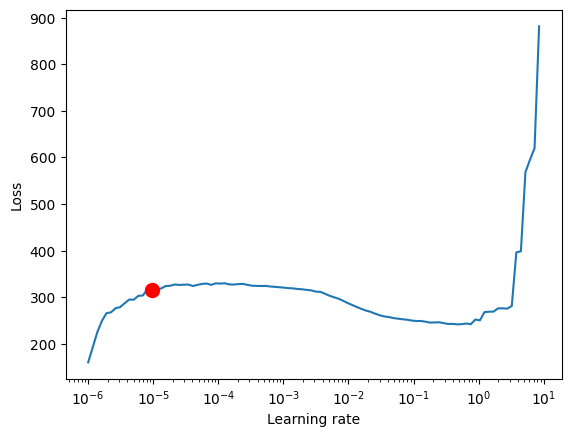

In [51]:
"""
STEP 5: FIND OPTIMAL LEARNING RATE
===================================

The learning rate is critical for training success:
- Too small: Very slow convergence, may get stuck in local minima
- Too large: Loss increases or diverges, gradients explode
- Just right: Fast convergence to good solution

This cell runs a learning rate finder that trains for 1 epoch with increasing
learning rates and plots the loss. Look for the steepest negative slope.

Warning: This can take 5-15 minutes depending on your data size.
"""

from lightning.pytorch.tuner import Tuner

print("Finding optimal learning rate...")
print("This may take several minutes...\n")

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,              # Test up to learning rate of 10.0
    min_lr=1e-6,              # Test down to 0.000001
)

suggested_lr = res.suggestion()
print(f"\nSuggested learning rate: {suggested_lr:.6f}")
print("\nLooking at the plot below:")
print("- The suggested LR is where loss decreases steepest")
print("- You can manually adjust based on the curve")
print("- Steep slope = good, flat = too slow, sharp rise = too fast")

fig = res.plot(show=True, suggest=True)
fig.show()

In [52]:
"""
STEP 6: TRAIN THE TFT MODEL
============================

This cell configures the full training setup and trains the model.

Key components:
1. Early Stopping: Stop training if validation loss doesn't improve for 10 epochs
2. Learning Rate Monitor: Log learning rate changes (useful with optimizers)
3. TensorBoard Logger: Log metrics to TensorBoard for visualization

Hyperparameters to adjust if needed:
- max_epochs: How many full passes through data (50 is reasonable)
- limit_train_batches: Use only first N batches per epoch (fast_dev_run mode)
- gradient_clip_val: Clip gradients to prevent instability
"""

# Define early stopping callback
# Stops training if validation loss doesn't improve for 10 consecutive epochs
early_stop_callback = EarlyStopping(
    monitor="val_loss",           # Metric to monitor
    min_delta=1e-4,               # Minimum change to qualify as improvement
    patience=10,                  # How many epochs to wait before stopping
    verbose=False,
    mode="min"                    # Lower val_loss is better
)

# Log learning rate during training
lr_logger = LearningRateMonitor()

# TensorBoard logging
# Results saved to ./lightning_logs/ which you can view with tensorboard
logger = TensorBoardLogger("lightning_logs")

# Configure trainer for full training
trainer = pl.Trainer(
    max_epochs=50,                     # Train for up to 50 epochs
    accelerator="cpu",                 # Use CPU (or "gpu" for NVIDIA GPU)
    enable_model_summary=True,         # Print model architecture
    gradient_clip_val=0.1,             # Prevent exploding gradients
    limit_train_batches=50,            # Use only first 50 batches per epoch
    # Set to 1.0 for full training, 0.1 for 10% training (faster testing)
    
    # Uncomment for quick testing:
    # fast_dev_run=True,  # Run 1 batch per epoch to check for bugs
    
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Create model with final hyperparameters
# Adjust these based on learning rate finder results and your hardware
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,            # Use suggested LR from lr_finder
    hidden_size=16,                # Can increase to 32/64 for better accuracy
    attention_head_size=2,         # More heads = more diverse attention patterns
    dropout=0.1,                   # Regularization (increase to 0.2-0.3 if overfitting)
    hidden_continuous_size=8,      # Hidden units for continuous features
    loss=QuantileLoss(),           # Quantile loss for prediction intervals
    log_interval=10,               # Log every 10 batches
    optimizer="ranger",            # RAdam with lookahead optimization
    reduce_on_plateau_patience=4,  # Reduce LR if no improvement for 4 epochs
)

num_params = tft.size() / 1e3
print(f"Training Temporal Fusion Transformer")
print(f"Model parameters: {num_params:.1f}k")
print(f"Max epochs: 50")
print(f"Learning rate: 0.03")
print(f"Early stopping patience: 10 epochs")
print(f"\nTraining may take 30-60 minutes depending on data size and hardware...")
print(f"Monitor progress in: ./lightning_logs/\n")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Training Temporal Fusion Transformer
Model parameters: 35.0k
Max epochs: 50
Learning rate: 0.03
Early stopping patience: 10 epochs

Training may take 30-60 minutes depending on data size and hardware...
Monitor progress in: ./lightning_logs/



In [53]:
"""
STEP 7: EXECUTE TRAINING
========================

This actually runs the training loop. The model will:
1. Load batches from train_dataloader
2. Forward pass through TFT model
3. Calculate loss using QuantileLoss
4. Backward pass to compute gradients
5. Update weights using Ranger optimizer
6. Validate on val_dataloader every epoch
7. Stop early if validation loss doesn't improve

Progress will be displayed in the output. Training typically takes:
- Small dataset (< 1 month data): 5-15 minutes
- Medium dataset (1-12 months data): 30-60 minutes
- Large dataset (> 1 year data): 1-3 hours
"""

print("Starting training...")
print("=" * 50)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

print("=" * 50)
print("Training completed!")
print(f"Best checkpoint saved at: {trainer.checkpoint_callback.best_model_path}")

Starting training...


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │    656 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    272 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │  1.8 K │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 11.2 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │  7.4 K │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  2.2 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  2.2 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │    544 │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     32 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  1.4 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │    808 │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │    576 │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  1.1 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │    576 │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    119 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 35.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 35.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 588                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


Training completed!
Best checkpoint saved at: lightning_logs\lightning_logs\version_1\checkpoints\epoch=49-step=2500.ckpt


In [ ]:
"""
STEP 8: HYPERPARAMETER OPTIMIZATION (OPTIONAL - ADVANCED)
==========================================================

This section uses Optuna to automatically search for optimal hyperparameters.
This is optional and can take several hours depending on n_trials.

Optuna performs Bayesian optimization to find hyperparameters that minimize
validation loss. Adjust n_trials based on your time budget:
- Quick test: n_trials=10 (30 min)
- Good search: n_trials=50 (3-5 hours)
- Thorough search: n_trials=200 (1-2 days)

IMPORTANT: Only run this if your initial model training works well.
"""

import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

print("Starting hyperparameter optimization with Optuna...")
print("This may take several hours.\n")

# Create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",           # Where to save trial models
    n_trials=10,                        # Number of trials (reduce for faster testing)
    max_epochs=50,                      # Max epochs per trial
    
    # Ranges to search over
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),         # From 8 to 128 hidden units
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),   # From 1 to 4 attention heads
    learning_rate_range=(0.001, 0.1),   # Learning rate range
    dropout_range=(0.1, 0.3),           # Dropout range
    
    trainer_kwargs=dict(limit_train_batches=30),  # Use fewer batches for speed
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # Skip LR finder to save time
)

# Save results
with open("optuna_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print("\nOptuna search completed!")
print(f"Best hyperparameters found:")
print(study.best_trial.params)

In [54]:
"""
STEP 9: LOAD BEST MODEL
=======================

After training completes, PyTorch Lightning saves checkpoints.
The best_model_path points to the checkpoint with lowest validation loss.

This cell loads that best model for evaluation and forecasting.
"""

# Load the best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Loading best model from checkpoint: {best_model_path}\n")

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print("Best model loaded successfully!")

Loading best model from checkpoint: lightning_logs\lightning_logs\version_1\checkpoints\epoch=49-step=2500.ckpt

Best model loaded successfully!


In [55]:
"""
STEP 10: EVALUATE MODEL ON VALIDATION SET
===========================================

Calculate Mean Absolute Error (MAE) on validation set.
This metric is in original units (MW or kW depending on your data).

Compare this to the baseline MAE from Step 3 to see improvement.
Expected improvement: 10-30% better than baseline (depends on problem difficulty)
"""

print("Evaluating model on validation set...\n")

# Make predictions on validation set
predictions = best_tft.predict(
    val_dataloader,
    return_y=True,
    trainer_kwargs=dict(accelerator="cpu")
)

# Calculate MAE
mae_metric = MAE()
model_mae = mae_metric(predictions.output, predictions.y)

print(f"Model MAE on validation set: {model_mae:.4f}")
print(f"Baseline MAE (from Step 3): {baseline_mae:.4f}")
improvement = ((baseline_mae - model_mae) / baseline_mae * 100)
print(f"Improvement over baseline: {improvement:.1f}%")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Evaluating model on validation set...

Model MAE on validation set: 118.6044
Baseline MAE (from Step 3): 204.0500
Improvement over baseline: 41.9%


In [ ]:
"""
STEP 11: EXTRACT DETAILED PREDICTIONS WITH QUANTILES
=====================================================

The TFT with QuantileLoss produces probabilistic forecasts:
- Point forecast: median prediction (50th percentile)
- Upper bound: 90th percentile (optimistic scenario)
- Lower bound: 10th percentile (pessimistic scenario)

This creates prediction intervals that quantify uncertainty.
Wider intervals = less confident, narrower = more confident
"""

print("Extracting detailed predictions with quantiles...\n")

# Make predictions in "raw" mode to get all quantiles
# mode='raw' gives access to the full model output including attention weights
raw_predictions = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu")
)

print(f"✓ Raw predictions extracted successfully")
print(f"Quantiles available: {best_tft.loss.quantiles}")
print(f"Number of prediction samples: {len(raw_predictions.output)}")
print("\nExample interpretation:")
print("- Quantile 0.1: 10% chance demand is below this")
print("- Quantile 0.5: 50% chance demand is above/below this (median)")
print("- Quantile 0.9: 10% chance demand is above this")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Extracting detailed predictions with quantiles...

✓ Raw predictions extracted successfully
Quantiles available: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Number of prediction samples: 8

Example interpretation:
- Quantile 0.1: 10% chance demand is below this
- Quantile 0.5: 50% chance demand is above/below this (median)
- Quantile 0.9: 10% chance demand is above this


Plotting 10 random prediction examples...
Blue=actual, Orange=forecast, Gray=confidence interval



IndexError: index 5 is out of bounds for dimension 0 with size 5

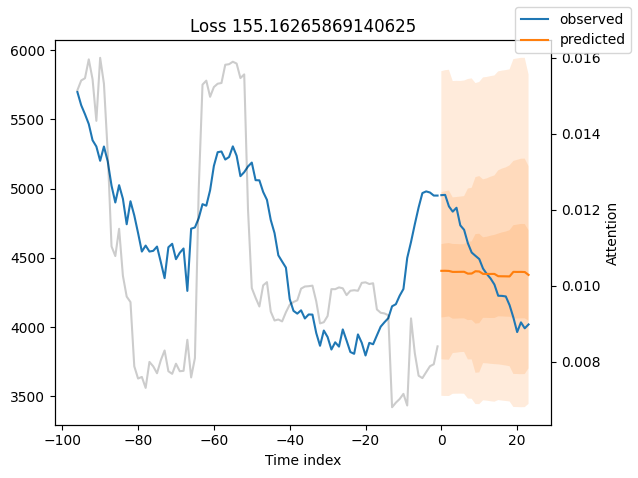

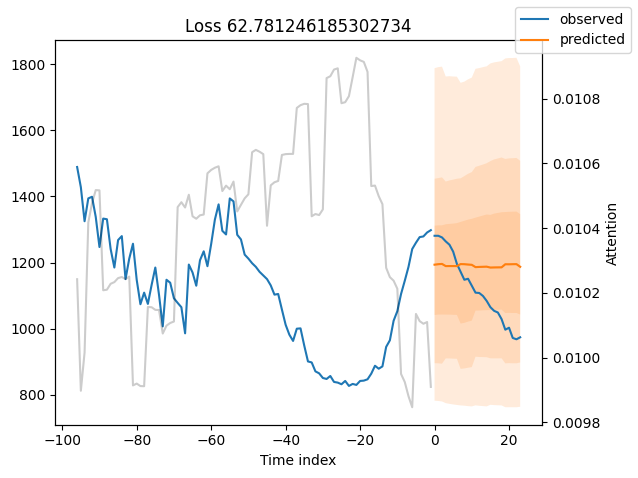

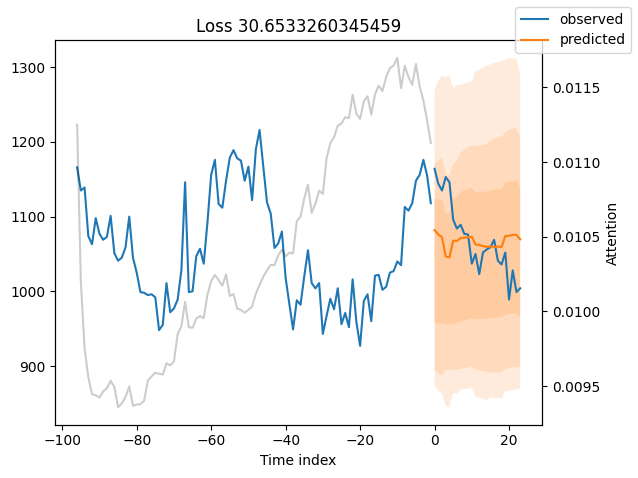

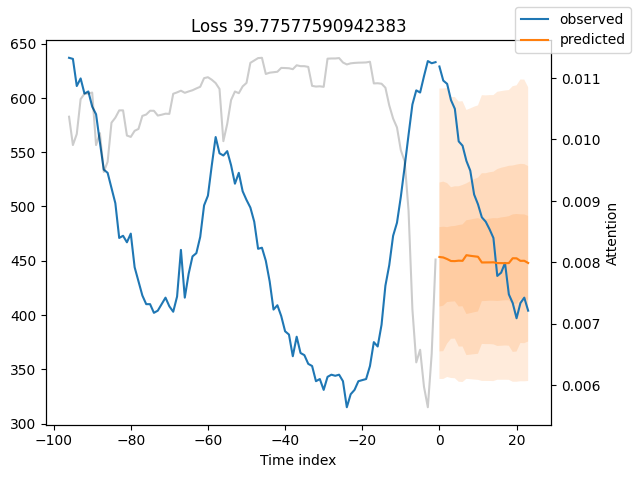

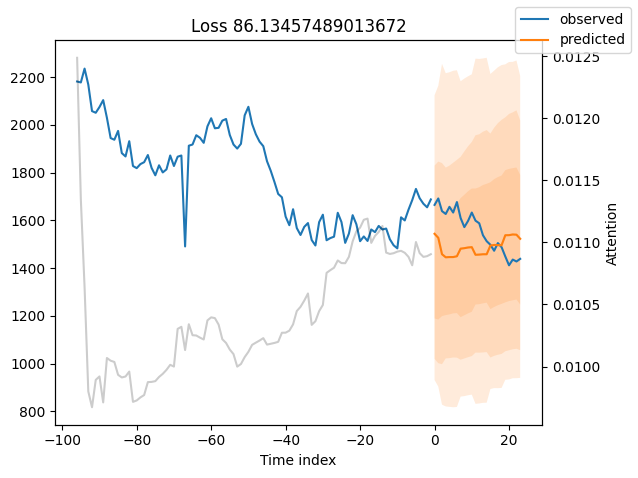

In [58]:
"""
STEP 12: VISUALIZE PREDICTIONS - RANDOM EXAMPLES
=================================================

Plot random validation sequences showing:
- Blue line: Actual historical demand (encoder period, 24h lookback)
- Blue dots: Actual demand in forecast period (6h ahead)
- Orange line: Model's median forecast
- Gray area: Confidence interval (10th-90th percentile)
- Loss printed above: How good was this prediction

These plots help understand:
1. Are predictions reasonable?
2. Does model capture trends?
3. Where does model struggle?
"""

print("Plotting 10 random prediction examples...")
print("Blue=actual, Orange=forecast, Gray=confidence interval\n")

for idx in range(10):
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=idx,
        add_loss_to_title=True  # Shows loss in title
    )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Identifying worst predictions (highest SMAPE)...

Worst SMAPE values found: tensor([0.1401, 0.0946, 0.0737, 0.0595, 0.0365])

Plotting 5 worst predictions:



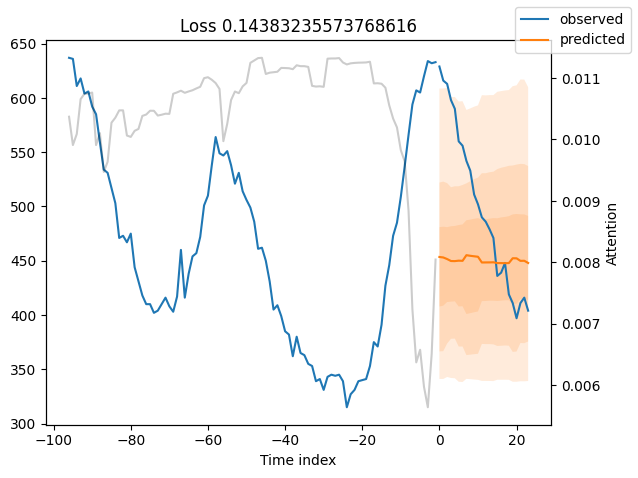

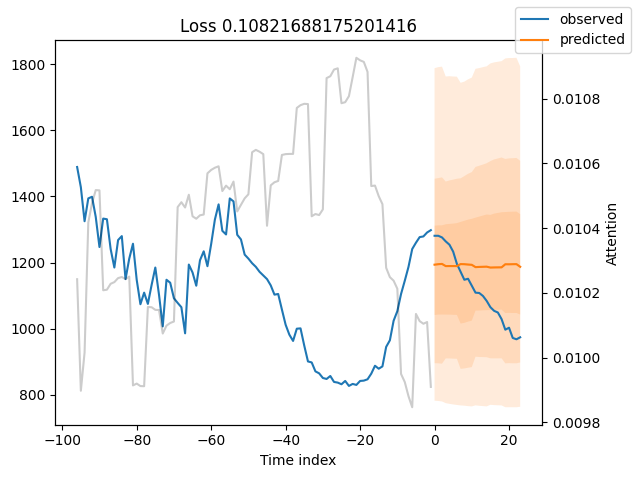

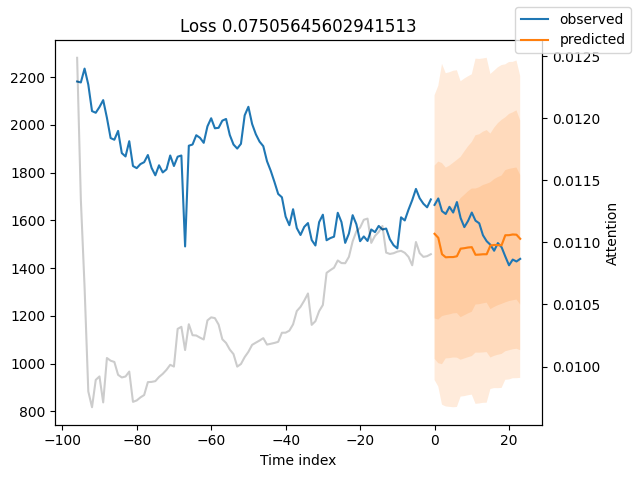

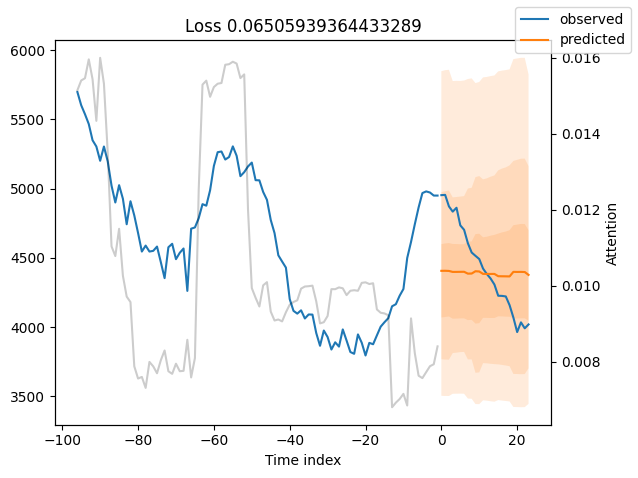

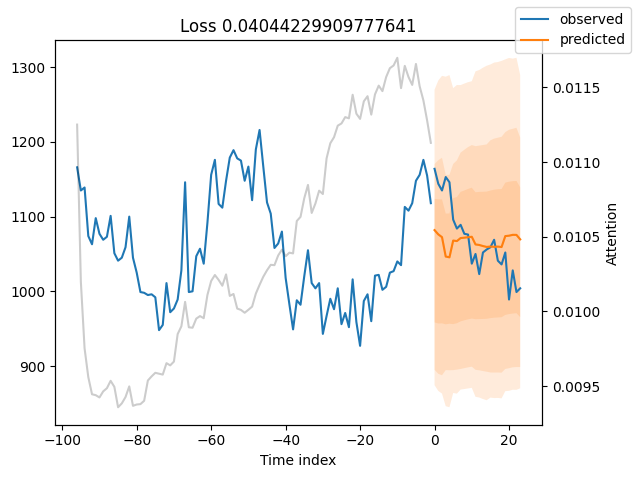

In [59]:
"""
STEP 13: VISUALIZE WORST PREDICTIONS
====================================

This section identifies and plots the 10 worst predictions (highest loss).
Analyzing these helps understand:
1. What conditions does the model struggle with?
2. Are there specific patterns it misses? (e.g., sudden demand spikes)
3. Should we adjust training or add more features?

SMAPE (Symmetric Mean Absolute Percentage Error) weights relative errors.
Perfect forecast: SMAPE = 0
Typical good model: SMAPE < 10-15%
"""

print("Identifying worst predictions (highest SMAPE)...\n")

# Re-predict to get SMAPE losses
predictions = best_tft.predict(
    val_dataloader,
    return_y=True,
    trainer_kwargs=dict(accelerator="cpu")
)

# Calculate SMAPE (percentage error) for each sequence
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)

# Get indices sorted by loss (worst first)
indices = mean_losses.argsort(descending=True)

num_to_plot = min(10, len(indices))  # Plot up to 10, but don't exceed available predictions

print(f"Worst SMAPE values found: {mean_losses[indices[:5]]}\n")
print(f"Plotting {num_to_plot} worst predictions:\n")

for idx in range(num_to_plot):
    worst_idx = indices[idx]
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=worst_idx,
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Analyzing feature importance and attention patterns...

Feature importance visualization:
X-axis: Input variables
Y-axis: Contribution to forecast

Vars with tall bars = model relies heavily on them
Vars with short bars = model ignores them



{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'demand_center': <Figure size 1000x500 with 2 Axes>,
 'demand_scale': <Figure size 1000x500 with 2 Axes>,
 'avg_demand_by_hour_zone': <Figure size 1000x500 with 2 Axes>,
 'temperature': <Figure size 1000x500 with 2 Axes>,
 'humidity': <Figure size 1000x500 with 2 Axes>,
 'wind_speed': <Figure size 1000x500 with 2 Axes>,
 'precipitation': <Figure size 1000x500 with 2 Axes>,
 'rain': <Figure size 1000x500 with 2 Axes>,
 'surface_pressure': <Figure size 1000x500 with 2 Axes>,
 'wind_direction': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'demand': <Figure size 1000x500 with 2 Axes>,
 'log_demand': <Figure size 1000x500 with 2 Axes>,
 'rolling_mean_1h': <Figure size 1000x500 with 2 Axes>,
 'rolling_mean_6h': <Figure size 1000x500 with 2 Axes>,
 'std_demand_by_hour_zone': <Figure size 1000x500 with 2 Axes>,
 'zone_id': <Figure size 640x480 with 2 Axes>,
 'hour': <Figure size 1000x500 w

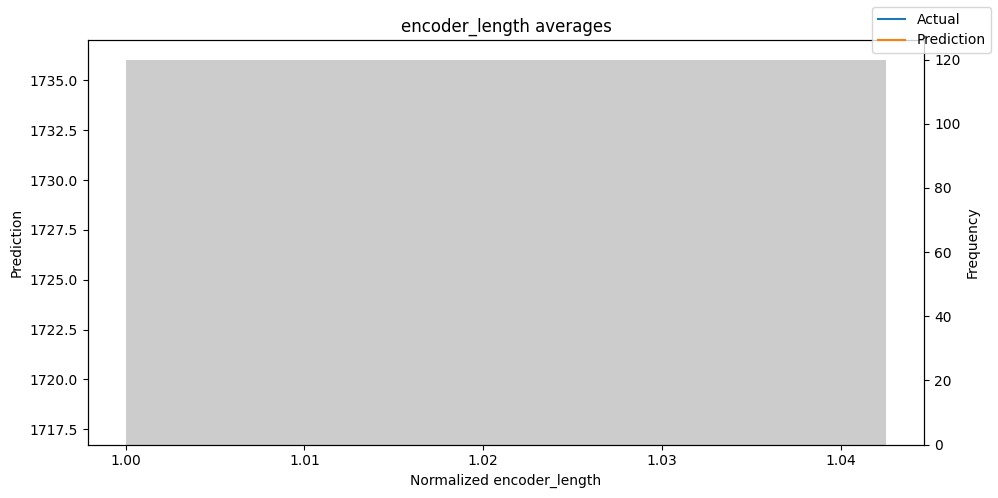

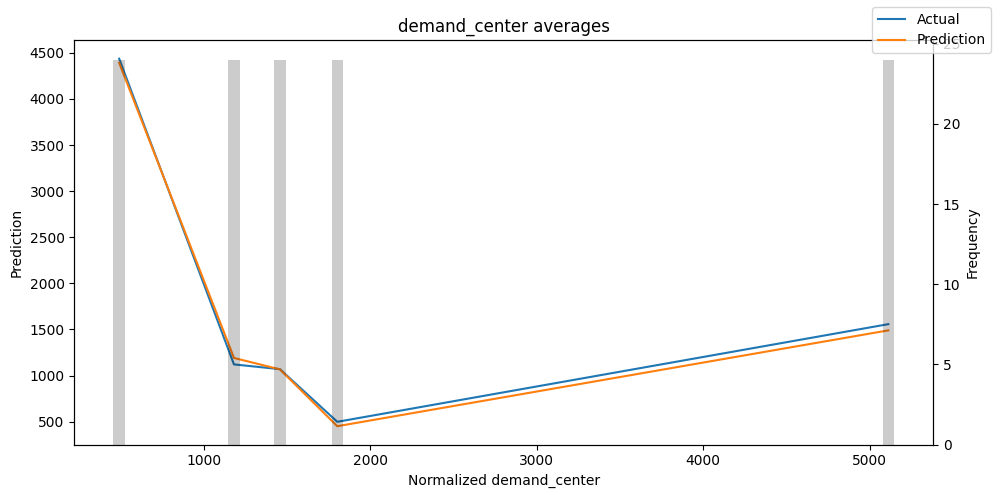

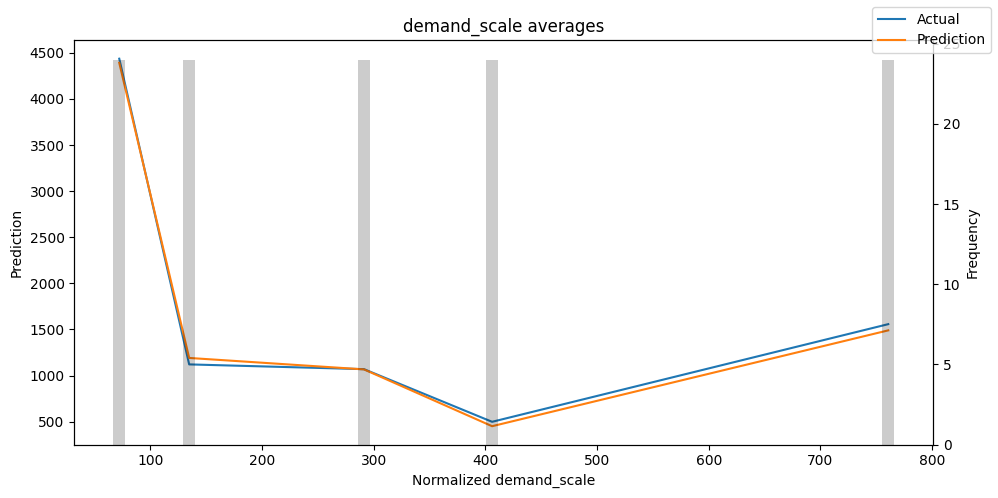

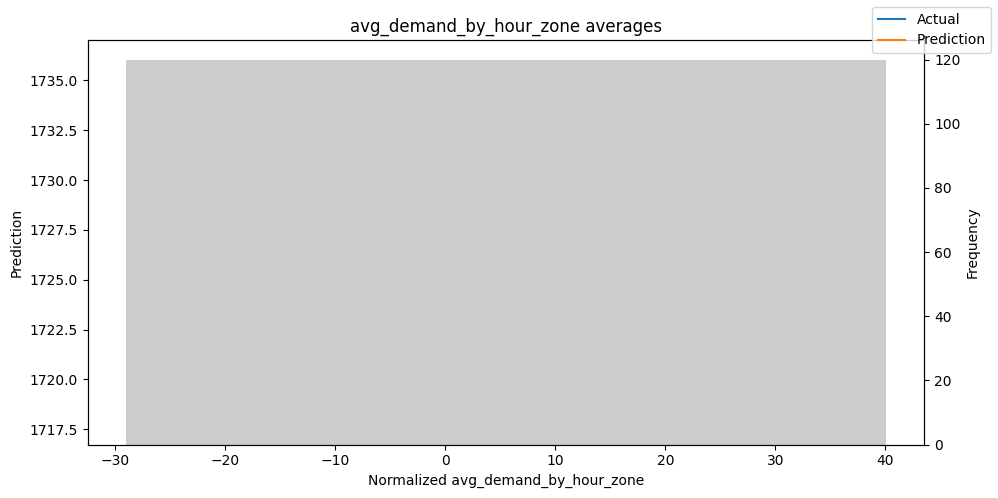

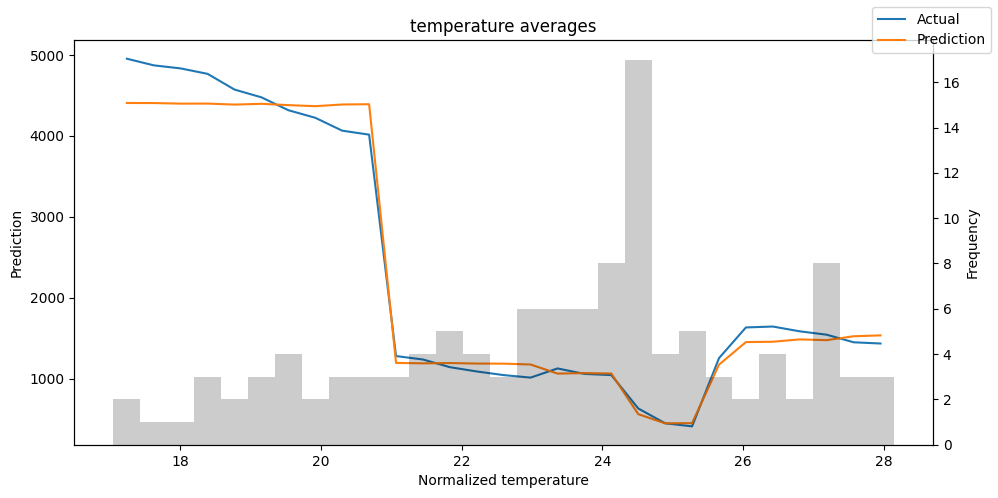

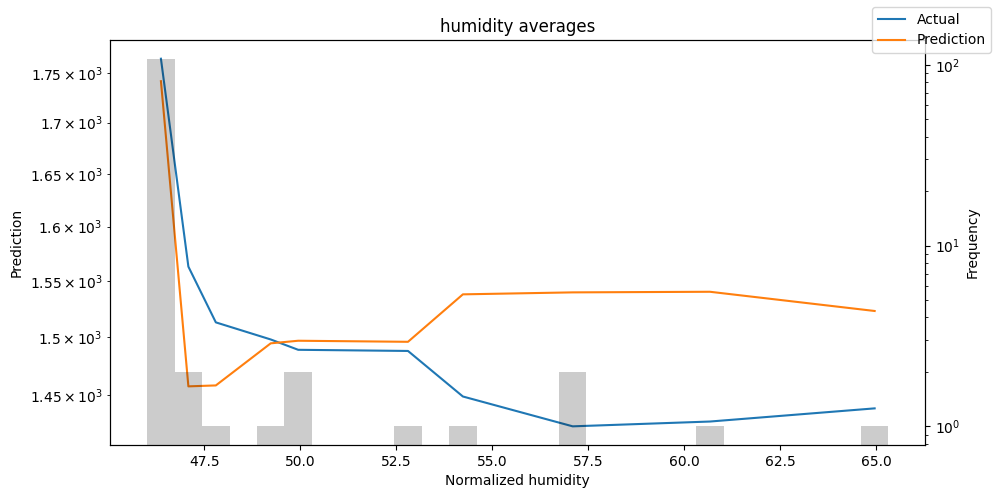

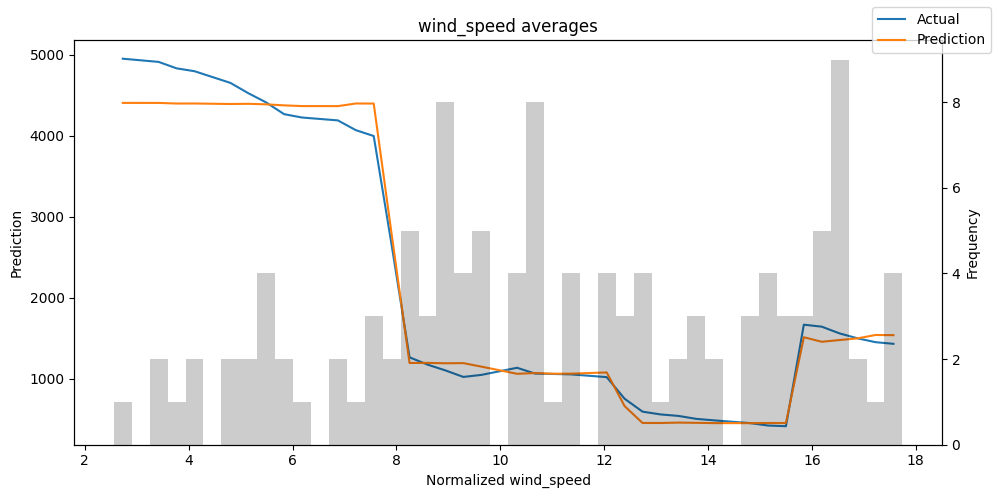

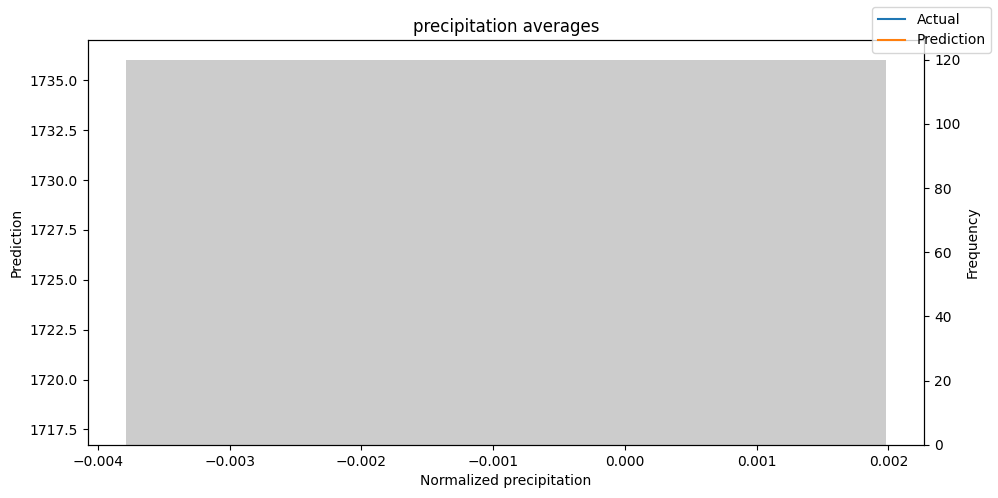

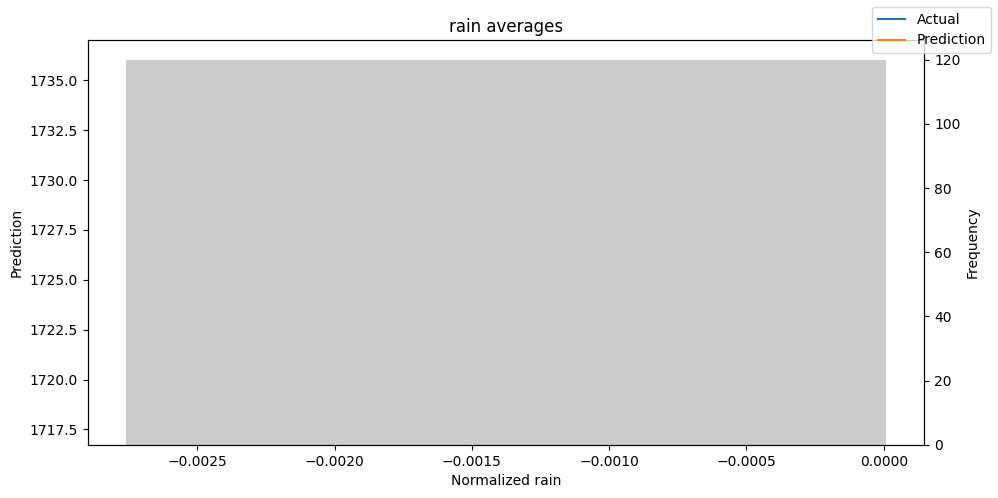

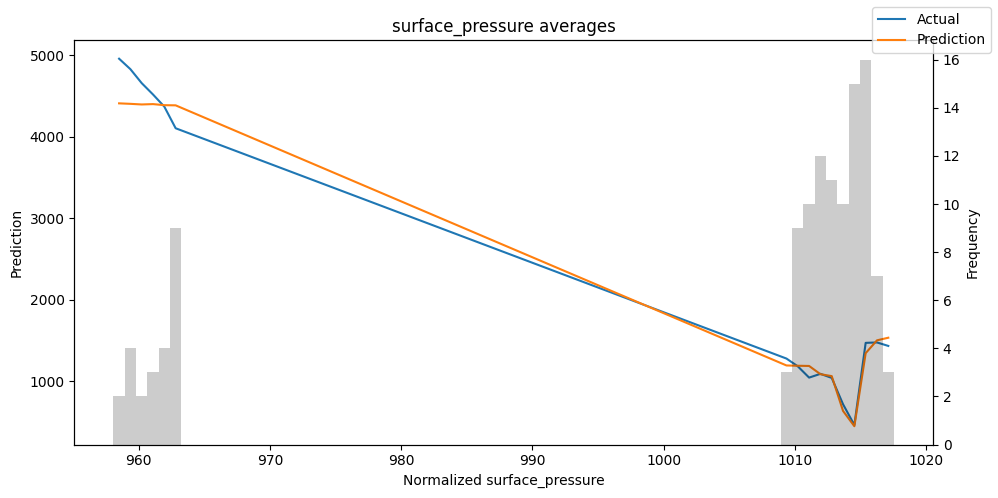

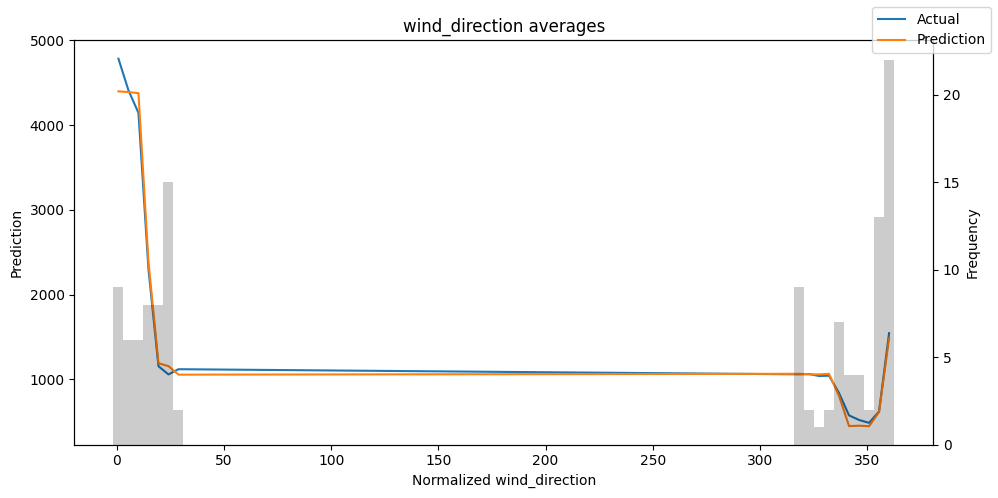

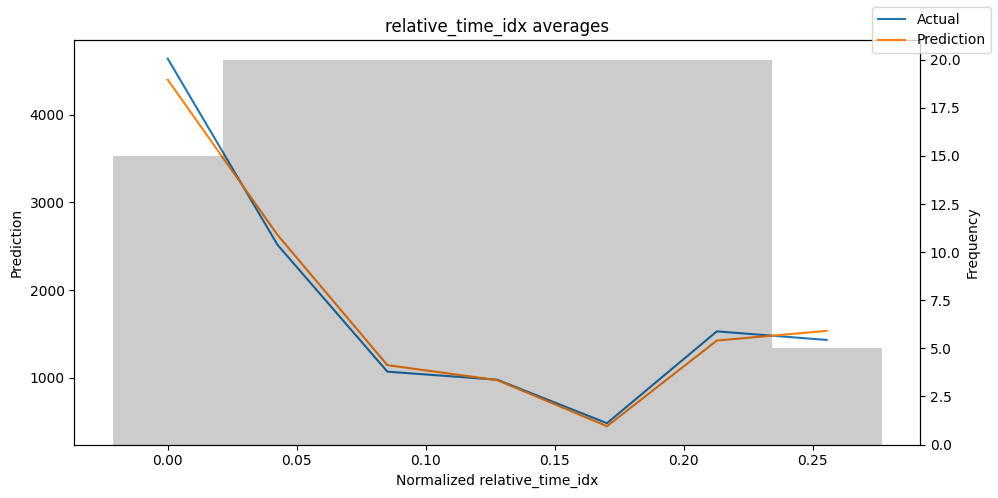

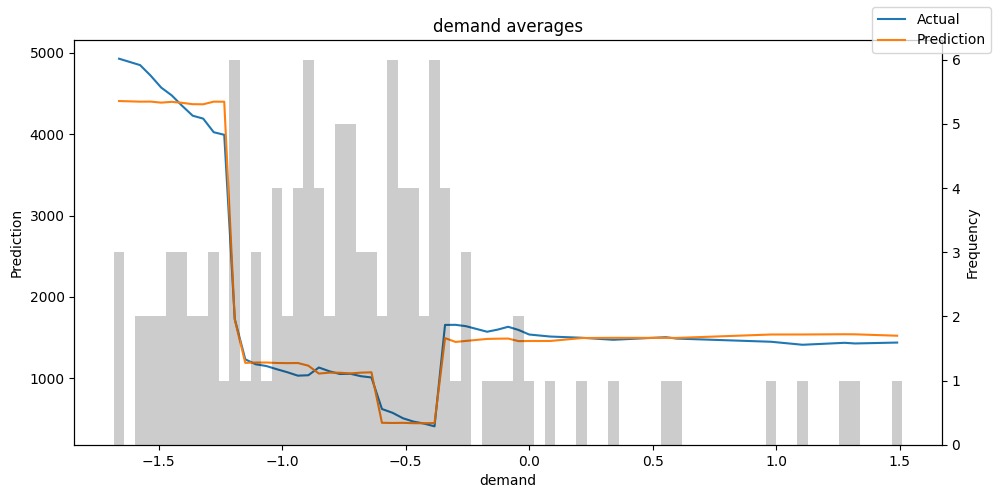

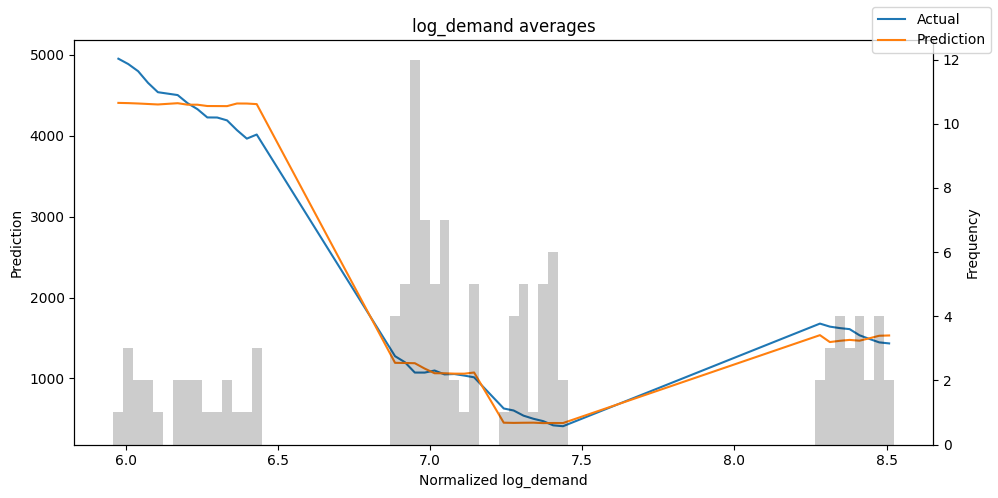

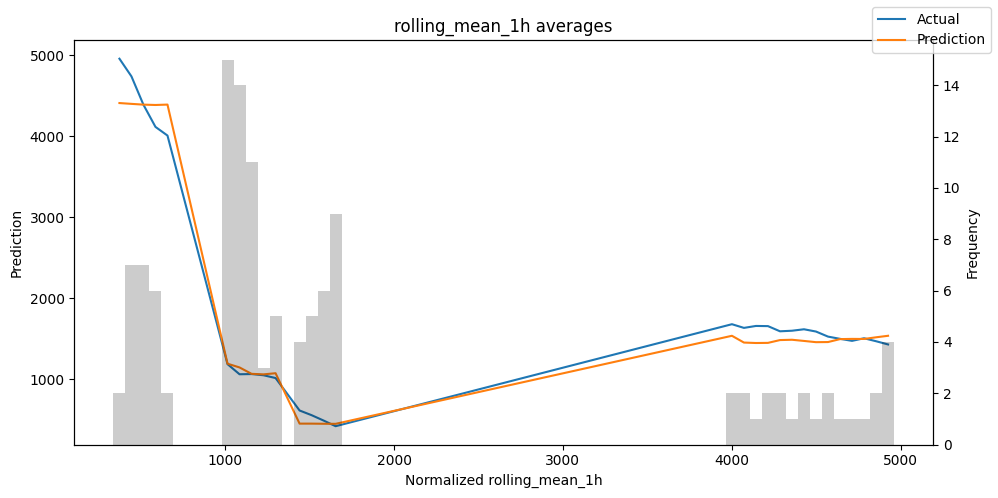

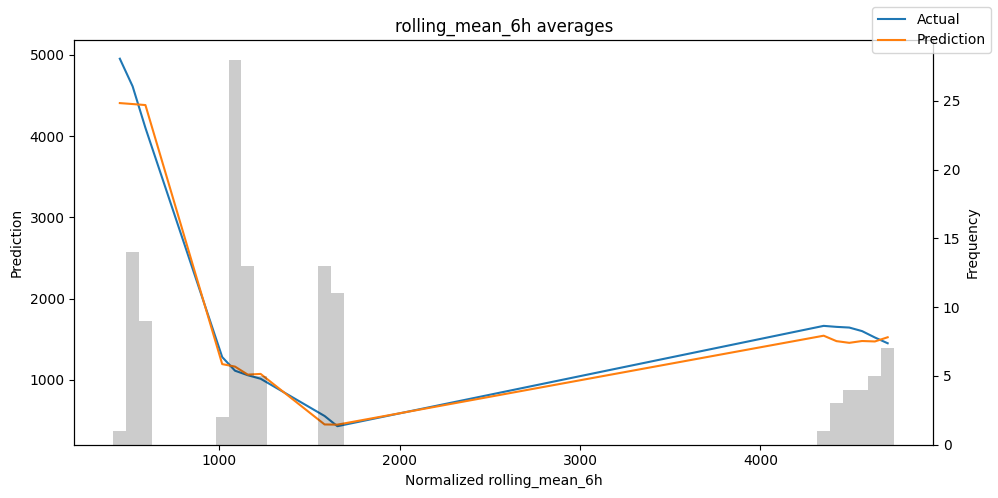

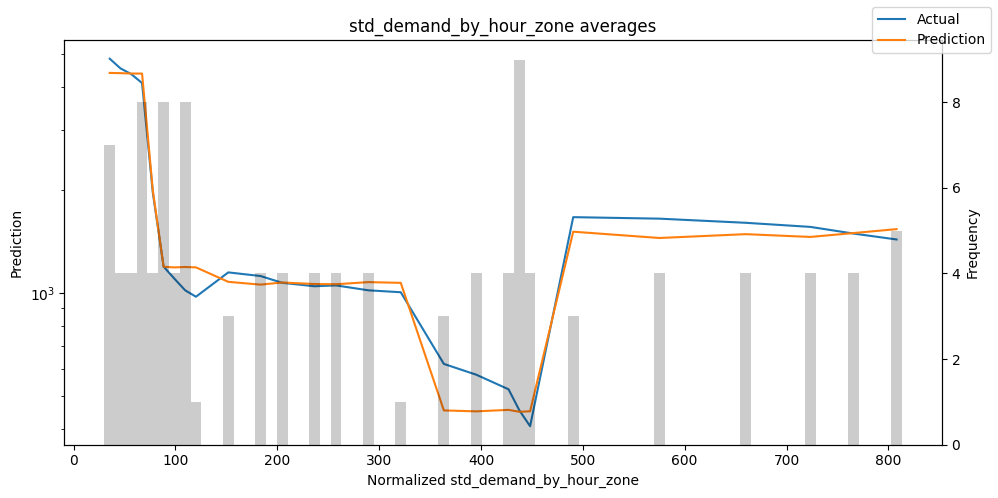

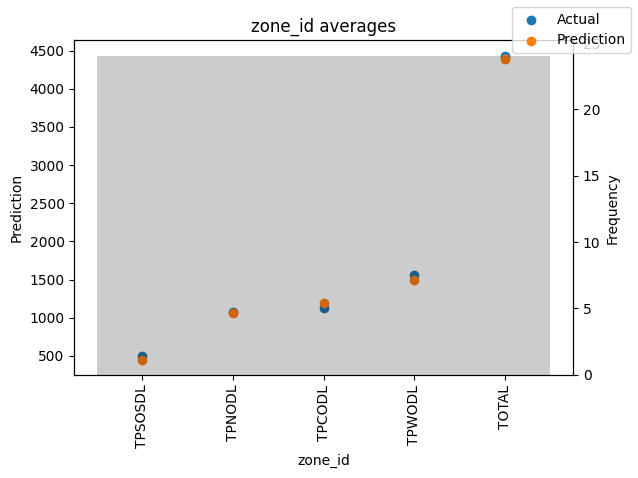

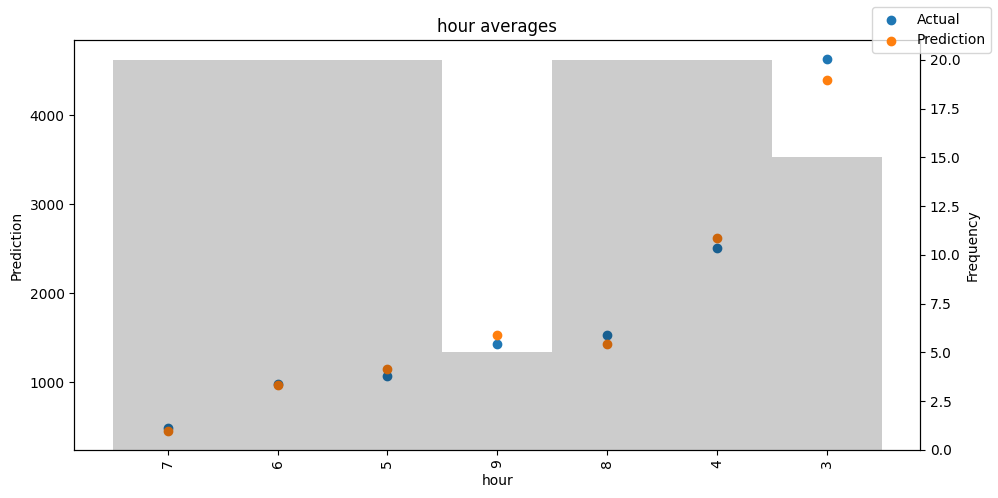

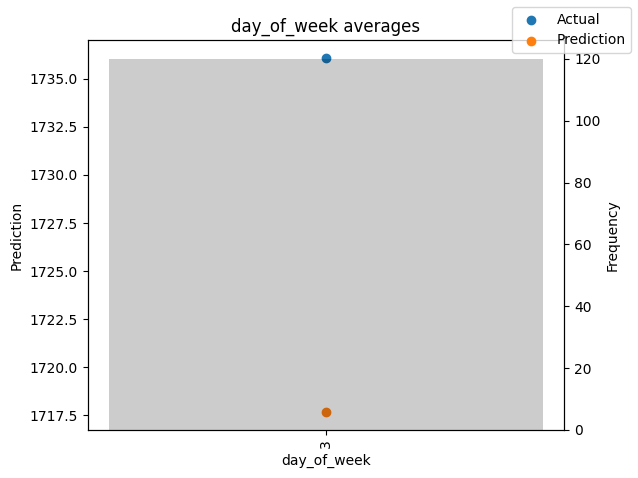

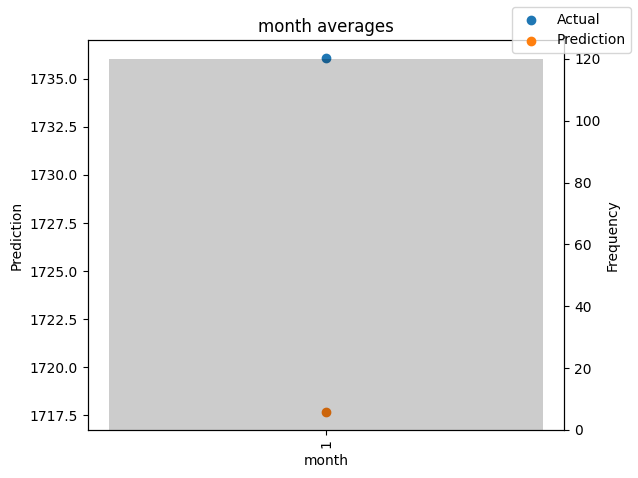

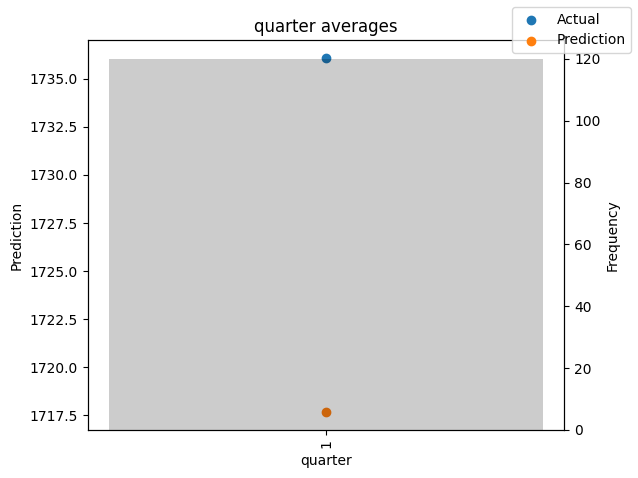

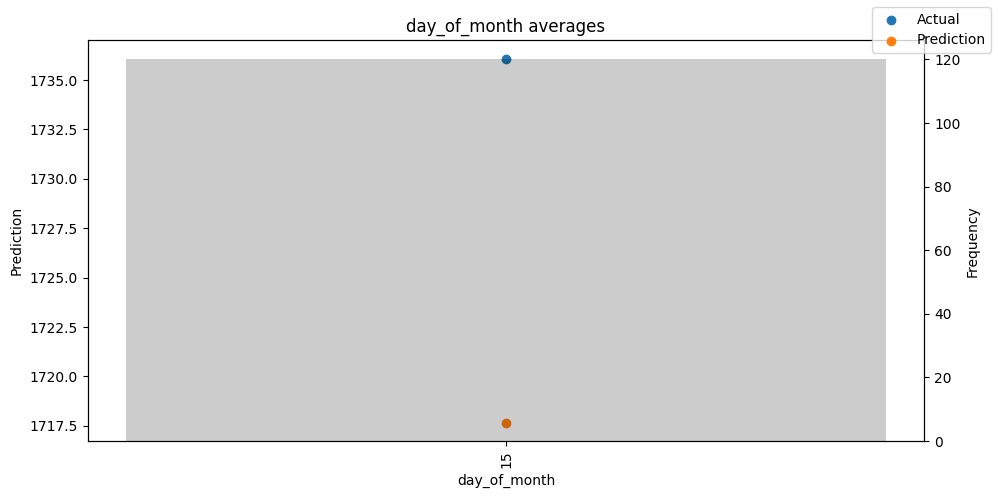

In [60]:
"""
STEP 14: ANALYZE FEATURE IMPORTANCE
===================================

TFT's attention mechanism provides interpretability:
- Shows which input variables the model relies on
- Shows which time steps are most important
- Helps identify if model makes sense

This cell creates heatmaps showing:
1. Which input variables (demand types, hour, day_of_week, etc.) are important
2. Which time steps in the lookback window matter most
"""

print("Analyzing feature importance and attention patterns...\n")

# Get predictions with feature importance
predictions = best_tft.predict(
    val_dataloader,
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu")
)

# Calculate average contribution by variable across all predictions
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x,
    predictions.output
)

print("Feature importance visualization:")
print("X-axis: Input variables")
print("Y-axis: Contribution to forecast")
print("\nVars with tall bars = model relies heavily on them")
print("Vars with short bars = model ignores them\n")

best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [61]:
"""
STEP 15: MAKE PREDICTIONS ON SPECIFIC TIME WINDOW
================================================

This filters the training set for a specific time period and group,
then makes predictions. Useful for:
- Testing on specific dates/times
- Creating forecasts for reports
- Analyzing model behavior on particular scenarios

Since we have a single group ("All_Regions"), we filter by time_idx.
"""

print("Making predictions on a specific time window...\n")

# Get a specific time window from the training data
# time_idx_first_prediction is the start of the forecast period
# Filter for sequences starting around index 1000

test_subset = training.filter(
    lambda x: (x.time_idx_first_prediction >= 1000) & (x.time_idx_first_prediction < 1010)
)

print(f"Found {len(test_subset)} sequences in this window\n")

# Get predictions for this subset
subset_predictions = best_tft.predict(
    test_subset,
    mode="quantiles",                    # Just get quantiles, not full output
    trainer_kwargs=dict(accelerator="cpu"),
)

print(f"Prediction shape: {subset_predictions.shape}")
print("Columns: 10th percentile, 50th (median), 90th percentile")
print("\nFirst 5 predictions:")
print(subset_predictions[:5])

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Making predictions on a specific time window...

Found 50 sequences in this window

Prediction shape: torch.Size([50, 24, 7])
Columns: 10th percentile, 50th (median), 90th percentile

First 5 predictions:
tensor([[[5072.8896, 5304.6279, 5503.6084, 5787.4902, 6018.9946, 6216.1035,
          6534.2222],
         [5004.3745, 5249.6006, 5454.3379, 5758.5742, 6012.0859, 6226.6074,
          6564.1450],
         [4940.6172, 5203.1226, 5416.6294, 5730.7793, 5998.6147, 6222.9019,
          6597.3550],
         [4998.4072, 5248.7412, 5441.9141, 5755.9619, 6007.4517, 6215.9341,
          6554.4814],
         [4997.5337, 5248.4136, 5440.9092, 5755.5073, 6007.6416, 6216.1328,
          6553.6147],
         [4997.1406, 5248.1909, 5440.2646, 5755.1660, 6007.6816, 6215.8916,
          6552.9370],
         [4997.8584, 5248.7153, 5440.2847, 5755.1460, 6007.7686, 6215.5459,
          6551.8306],
         [4987.2832, 5244.6484, 5458.1548, 5748.5874, 6018.1187, 6251.8857,
          6574.9595],
         [4

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Creating detailed plot for specific time window...

Detailed visualization of prediction starting at index ~1000:


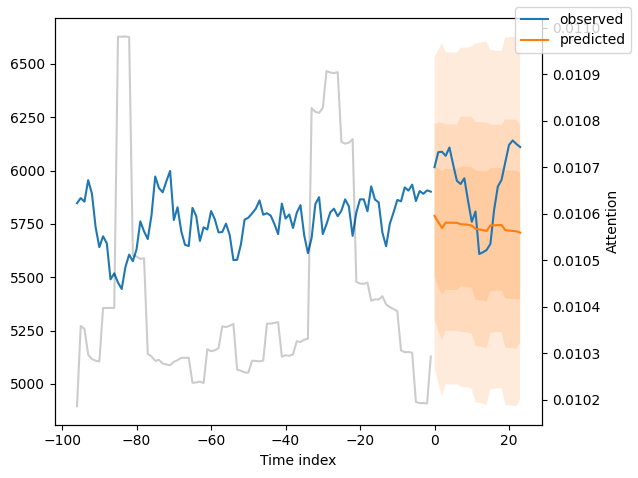

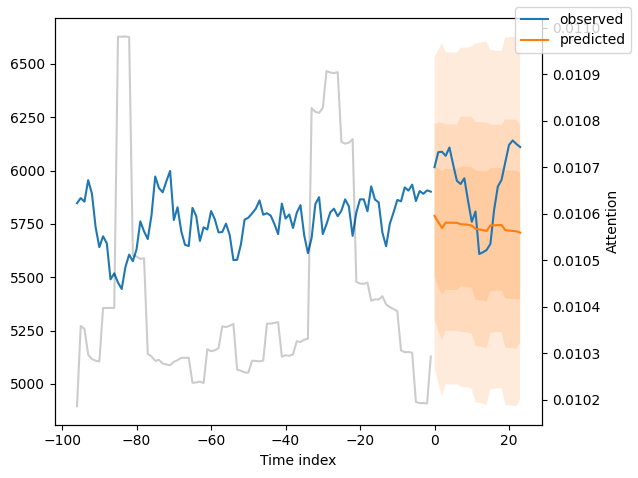

In [62]:
"""
STEP 16: DETAILED PLOT FOR SPECIFIC TIME WINDOW
===============================================

Plot a specific prediction in detail showing:
- Historical demand (24h)
- Forecasted demand (6h)
- Confidence interval
- Feature importance
"""

print("Creating detailed plot for specific time window...\n")

raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.time_idx_first_prediction >= 1000) & (x.time_idx_first_prediction < 1010)
    ),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

# Plot the first prediction in this window
print("Detailed visualization of prediction starting at index ~1000:")
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [63]:
"""
STEP 17: FUTURE FORECASTING WITH WEATHER FORECAST
==================================================

Make forecasts for future periods using:
1. Last 24 hours of actual demand (encoder input)
2. Forecasted weather for the next 6 hours (key covariate)

The model uses the weather forecast to predict how demand will respond to
expected temperature, humidity, wind, and precipitation changes.

Process:
1. Take last 24 hours of actual data (encoder_length)
2. Get next 6 hours of forecasted weather
3. Create future timesteps with forecasted weather values
4. Model predicts demand incorporating weather forecast
"""

print("=" * 80)
print("STEP 17: FUTURE FORECASTING WITH WEATHER FORECAST")
print("=" * 80)

# Select last 24 hours of actual data for context
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

print(f"\nHistorical data (encoder input):")
print(f"  Observations: {len(encoder_data)}")
print(f"  Date range: {encoder_data['Timestamp'].min()} to {encoder_data['Timestamp'].max()}")

# Take the last observation per zone for base information
last_data = data[lambda x: x.time_idx == x.time_idx.max()]

print(f"\nLast recorded observation per zone:")
for zone in last_data['zone_id'].unique():
    zone_last = last_data[last_data['zone_id'] == zone]
    ts = zone_last['Timestamp'].iloc[0]
    demand = zone_last['demand'].iloc[0]
    print(f"  {zone}: {ts} - Demand: {demand:.2f}")

# ============================================================================
# MERGE WITH WEATHER FORECAST
# ============================================================================
print(f"\nWeather forecast data (for future predictions):")
print(f"  Observations: {len(weather_forecast_latest)}")
print(f"  Date range: {weather_forecast_latest['Timestamp'].min()} to {weather_forecast_latest['Timestamp'].max()}")

# Get the next 6 hours (max_prediction_length) of forecasted weather
# Start from the last timestamp + 15 minutes
last_timestamp = data['Timestamp'].max()
forecast_start = last_timestamp + pd.Timedelta(minutes=15)
forecast_end = forecast_start + pd.Timedelta(minutes=15 * (max_prediction_length - 1))

forecast_subset = weather_forecast_latest[
    (weather_forecast_latest['Timestamp'] >= forecast_start) &
    (weather_forecast_latest['Timestamp'] <= forecast_end)
].copy()

print(f"\nForecast subset for next 6 hours:")
print(f"  Timestamps: {forecast_subset['Timestamp'].min()} to {forecast_subset['Timestamp'].max()}")
print(f"  Total records: {len(forecast_subset)}")

if len(forecast_subset) == 0:
    print(f"\n⚠ WARNING: No forecast data in the next 6 hours!")
    print(f"  Available forecast range: {weather_forecast_latest['Timestamp'].min()} to {weather_forecast_latest['Timestamp'].max()}")
    print(f"  Will use last available forecast by forward-filling")
    # Use all available forecast data
    forecast_subset = weather_forecast_latest.copy()

# ============================================================================
# CREATE DECODER DATA WITH FORECAST WEATHER
# ============================================================================
# Expand last_data to match forecast_subset
decoder_data_base = pd.concat(
    [last_data] * len(forecast_subset),
    ignore_index=True
)

# Update timestamps and other time features
decoder_data_base['Timestamp'] = forecast_subset['Timestamp'].values
decoder_data_base['hour'] = decoder_data_base['Timestamp'].dt.hour.astype(str).astype('category')
decoder_data_base['day_of_week'] = decoder_data_base['Timestamp'].dt.dayofweek.astype(str).astype('category')
decoder_data_base['month'] = decoder_data_base['Timestamp'].dt.month.astype(str).astype('category')
decoder_data_base['quarter'] = decoder_data_base['Timestamp'].dt.quarter.astype(str).astype('category')
decoder_data_base['day_of_month'] = decoder_data_base['Timestamp'].dt.day.astype(str).astype('category')

# ============================================================================
# MERGE WITH FORECASTED WEATHER
# ============================================================================
# Merge decoder data with forecasted weather
decoder_data = decoder_data_base[['Timestamp', 'zone_id', 'hour', 'day_of_week', 
                                   'month', 'quarter', 'day_of_month', 'demand',
                                   'rolling_mean_1h', 'rolling_mean_6h', 'log_demand',
                                   'avg_demand_by_hour_zone', 'std_demand_by_hour_zone']].copy()

# Merge with weather forecast (this is KEY - using predicted weather!)
decoder_data = decoder_data.merge(
    forecast_subset[['Timestamp', 'zone_id'] + weather_features],
    on=['Timestamp', 'zone_id'],
    how='left'
)

# Forward fill any missing forecast weather values
print(f"\nMerging forecast weather with decoder data...")
for col in weather_features:
    if col in decoder_data.columns:
        missing_before = decoder_data[col].isnull().sum()
        decoder_data[col] = decoder_data.groupby('zone_id')[col].fillna(method='ffill')
        missing_after = decoder_data[col].isnull().sum()
        if missing_before > 0:
            print(f"  {col:20s}: {missing_before} → {missing_after} missing values")

# Update time_idx for future data (continuous from last observation)
last_time_idx = data[data['zone_id'] == 'TPCODL']['time_idx'].max()
decoder_data['time_idx'] = decoder_data.groupby('zone_id').cumcount() + last_time_idx + 1

# Combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

print(f"\n✓ Forecast data prepared:")
print(f"  Historical: {len(encoder_data)} observations (24 hours)")
print(f"  Forecast: {len(decoder_data)} observations (6 hours)")
print(f"  Total: {len(new_prediction_data)} observations")
print(f"\nForecast timestamps:")
for ts in decoder_data['Timestamp'].unique()[:5]:
    print(f"  {ts}")
if len(decoder_data['Timestamp'].unique()) > 5:
    print(f"  ... and {len(decoder_data['Timestamp'].unique()) - 5} more")

print(f"\n✓ KEY: Using FORECASTED weather for future demand predictions")
print(f"✓ Model will respond to expected temperature, humidity, wind changes")

STEP 17: FUTURE FORECASTING WITH WEATHER FORECAST

Historical data (encoder input):
  Observations: 470
  Date range: 2026-01-14 09:15:00 to 2026-01-15 09:00:00

Last recorded observation per zone:
  TPCODL: 2026-01-15 09:00:00 - Demand: 974.00

Weather forecast data (for future predictions):
  Observations: 2880
  Date range: 2026-01-17 00:00:00 to 2026-01-17 23:45:00

Forecast subset for next 6 hours:
  Timestamps: NaT to NaT
  Total records: 0

⚠ WARNING: No forecast data in the next 6 hours!
  Available forecast range: 2026-01-17 00:00:00 to 2026-01-17 23:45:00
  Will use last available forecast by forward-filling

Merging forecast weather with decoder data...

✓ Forecast data prepared:
  Historical: 470 observations (24 hours)
  Forecast: 2880 observations (6 hours)
  Total: 3350 observations

Forecast timestamps:
  2026-01-17 00:00:00
  2026-01-17 00:15:00
  2026-01-17 00:30:00
  2026-01-17 00:45:00
  2026-01-17 01:00:00
  ... and 91 more

✓ KEY: Using FORECASTED weather for futu

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


Generating future forecasts and visualizations...

Number of forecasts generated: 8

Plotting 10 future forecast examples:
Left=Historical (24h), Right=Forecast (6h)



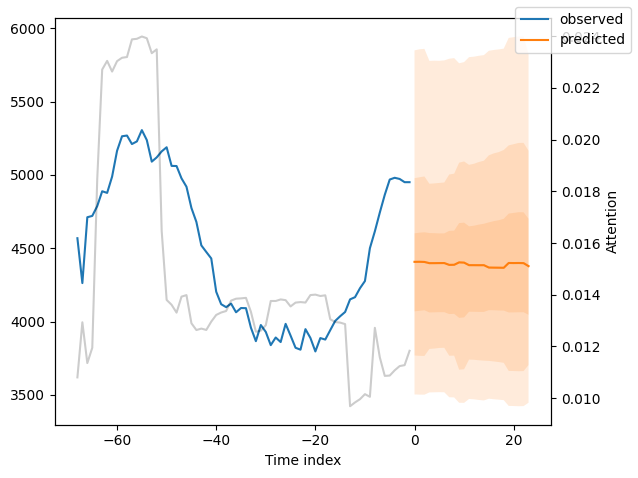

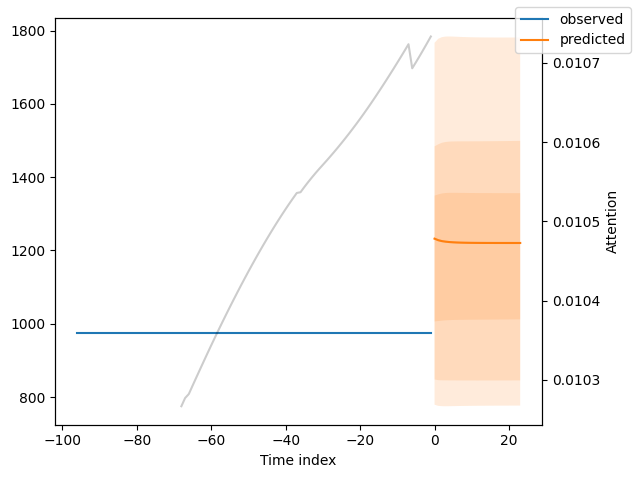

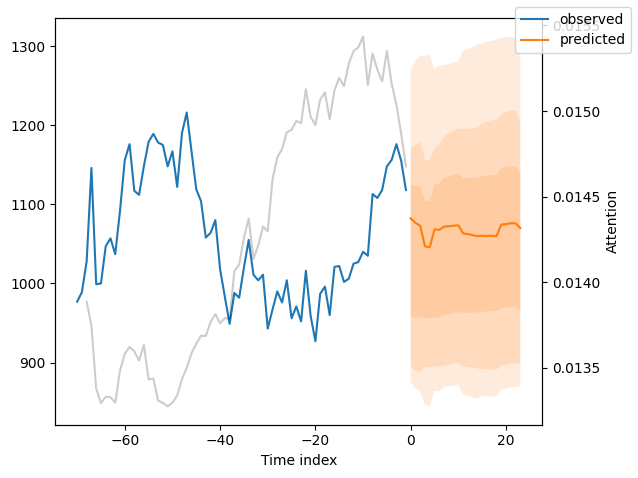

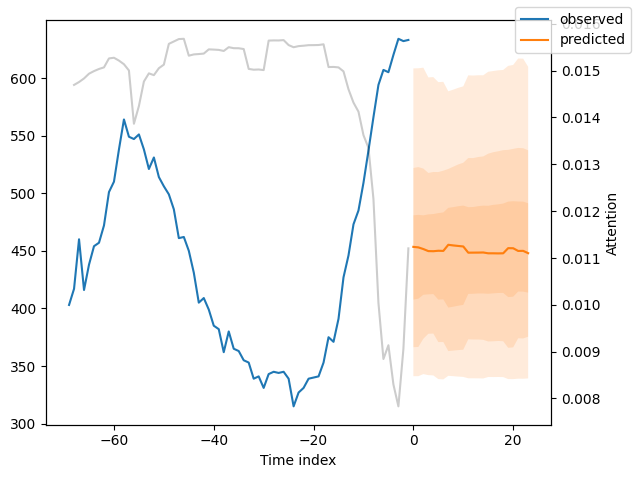

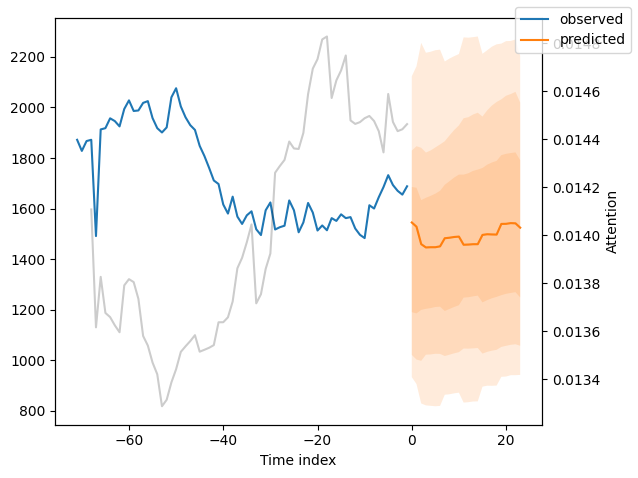

In [65]:
"""
STEP 18: VISUALIZE FUTURE FORECAST
==================================

Plot 10 different future forecast scenarios.
Each represents a different initial condition (different hours/days).

Interpretation:
- Left side (blue): Last 24h actual demand (historical context)
- Right side (orange): Next 6h predicted demand
- Gray band: Confidence interval (10%-90% percentile)
"""

print("Generating future forecasts and visualizations...\n")

new_raw_predictions = best_tft.predict(
    new_prediction_data,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

print(f"Number of forecasts generated: {len(new_raw_predictions.output)}\n")
print("Plotting 10 future forecast examples:")
print("Left=Historical (24h), Right=Forecast (6h)\n")

for idx in range(min(5, len(new_raw_predictions.output))):
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,  # No actual values for future
    )

Analyzing attention patterns and feature importance...


Plotting attention heatmaps...


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x675 with 1 Axes>,
 'decoder_variables': <Figure size 700x550 with 1 Axes>}

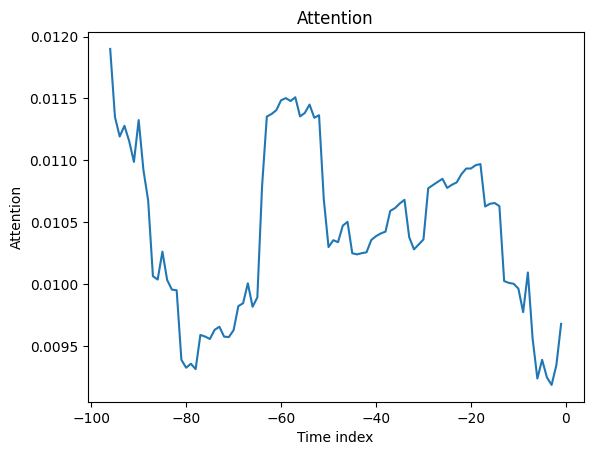

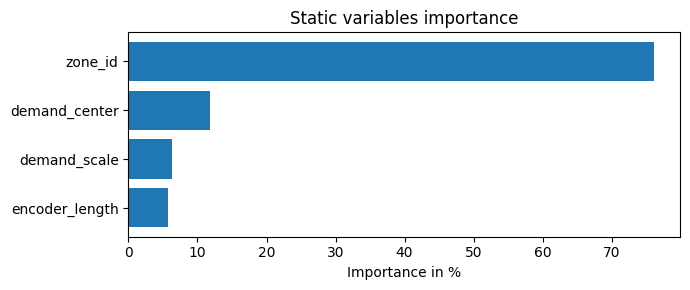

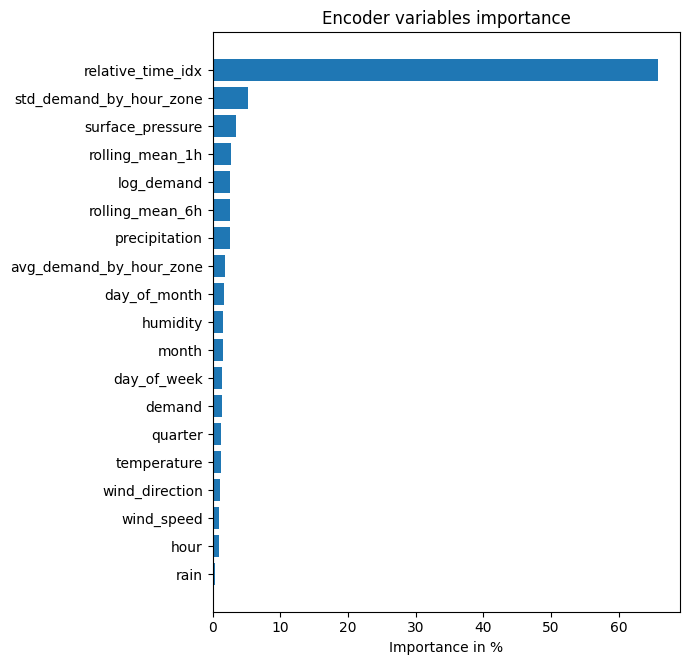

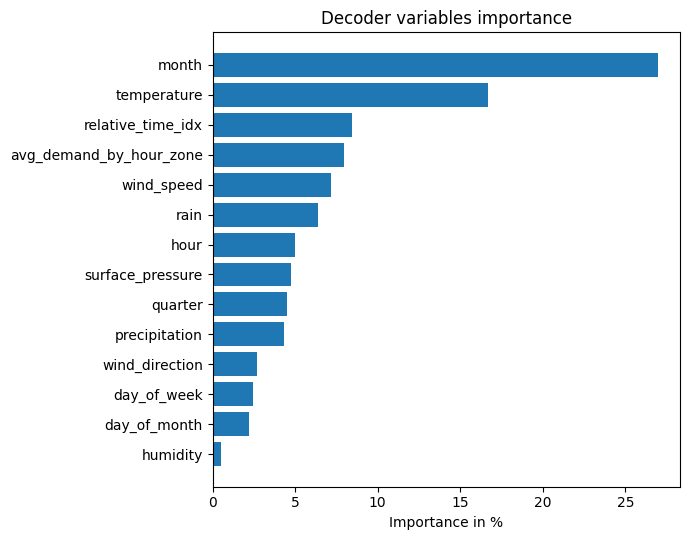

In [68]:
"""
STEP 19: MODEL INTERPRETABILITY - ATTENTION ANALYSIS
===================================================

The TFT uses multi-head attention. This visualization shows:
1. Which input variables the model attends to most
2. Which time steps are most important
3. Overall attention patterns

Helpful for understanding:
- Is the model learning reasonable patterns?
- Does it over-rely on one variable?
- Do attention patterns make business sense?
"""

print("Analyzing attention patterns and feature importance...\n")

# Calculate attention-based interpretation
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")

# print("Interpretation shapes:")
# print(f"  - Static features: {interpretation['static'].shape}")
# print(f"  - Encoder features: {interpretation['encoder'].shape}")
# print(f"  - Decoder features: {interpretation['decoder'].shape}")

print("\nPlotting attention heatmaps...")
best_tft.plot_interpretation(interpretation)

In [ ]:
"""
STEP 20: SENSITIVITY ANALYSIS - HOW DOES DEMAND CHANGE WITH FEATURES?
=====================================================================

This analyzes how demand varies with a specific feature (e.g., hour of day).
Shows the model's learned relationship between variables and predictions.

We can change the variable being analyzed:
- "avg_demand_by_hour_zone": Average demand by hour and zone
- "rolling_mean_1h": 1-hour rolling average demand
- "rolling_mean_6h": 6-hour rolling average demand

This helps validate that model learned meaningful relationships.
"""

print("Analyzing model sensitivity to 'avg_demand_by_hour_zone' variable...\n")
print("This may take 2-5 minutes...\n")

# Create a range of values for the variable to analyze
sensitivity_var = "avg_demand_by_hour_zone"
var_range = np.linspace(
    data[sensitivity_var].quantile(0.1),
    data[sensitivity_var].quantile(0.9),
    30
)

dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    sensitivity_var,
    var_range,
    show_progress_bar=True,
    mode="dataframe",
    trainer_kwargs=dict(accelerator="cpu"),
)

print(f"\nSensitivity analysis completed!")
print(f"Dependency dataframe shape: {dependency.shape}")
print(f"\nFirst few rows:")
print(dependency.head())

Analyzing model sensitivity to 'avg_demand_by_hour_zone' variable...

This may take 2-5 minutes...



Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint


Sensitivity analysis completed!
Dependency dataframe shape: (150, 6)

First few rows:
   time_idx  zone_id   prediction  temperature  normalized_prediction  id
0     19050    TOTAL  4378.114746          0.8                    1.0   0
1     19054   TPCODL  1178.817261          0.8                    1.0   1
2     19052   TPNODL  1042.673828          0.8                    1.0   2
3     19051  TPSOSDL   447.909821          0.8                    1.0   3
4     19053   TPWODL  1414.673950          0.8                    1.0   4


Plotting feature dependence curve...

Relationship between temperature and demand visualized

Key insight:
✓ Positive relationship: Higher temperature → Higher demand


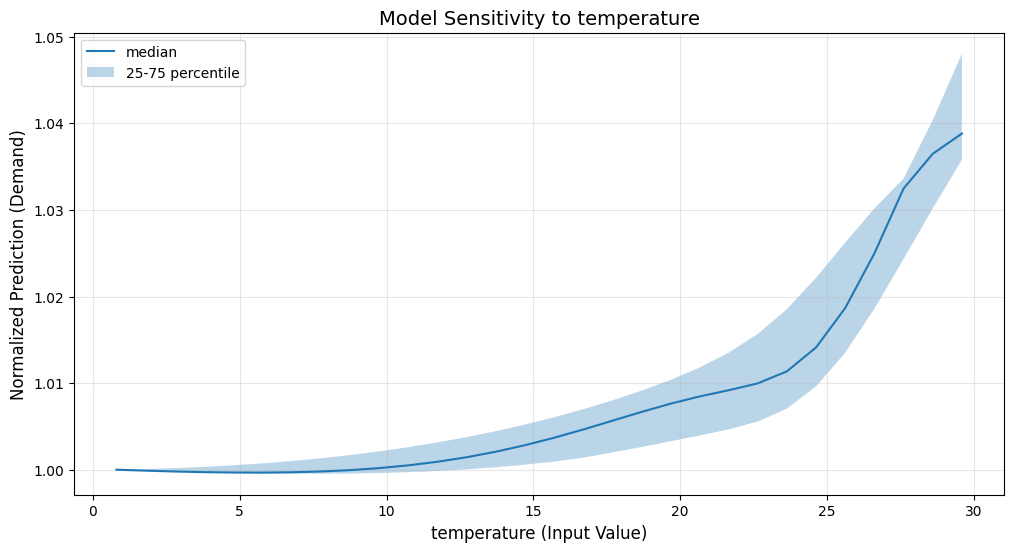

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)